<h1><center> Comparing multiple techniques to predict bitcoin prices(Bayesian Hyperparameter Optimization) </center></h1>
<h1><center> Love Rawat </center></h1>

In [1]:
## Importing necessary libraries
import numpy as np
import pandas as pd
import random
import math
import matplotlib as mlt
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
from IPython.display import Image
from pandas_datareader import data as pdr
import statsmodels.api as sm
from statsmodels.multivariate.pca import PCA


import yfinance as yf

import quandl as quandl
quandl.ApiConfig.api_key = 'BzVGriov2pgK4PAYr4sy'

%config InlineBackend.figure_format = 'svg'
sns.set_style("darkgrid")

import warnings
warnings.filterwarnings('ignore')

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:70% !important; }</style>"))

pd.set_option('display.max_colwidth', -1)

import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

import keras

In [214]:
display(HTML("<style>.container { width:70% !important; }</style>"))


In [60]:
from kerastuner.tuners import RandomSearch
from kerastuner.engine.hyperparameters import HyperParameters

from kerastuner.tuners import BayesianOptimization

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
import os

# Part 1: Data gathering and Analysis

##### Helper Functions

In [2]:
def cal_perc_missing(df, title = '', rotate_angle = 0, figsize = (10,3)):
    miss_per = pd.DataFrame(df.isnull().sum(axis =0)*100/df.shape[0], columns=['Missing %']).round(3).sort_values(by=['Missing %'], ascending=False)
    display(miss_per.T)
    plt.figure(figsize = figsize)
    plt.xticks(rotation = rotate_angle)
    plt.title(title)
    plt.ylabel('Missing %')
    plt.xlabel('Features')
    plt.ylim(0,100)
    _ = plt.bar(x = miss_per.index, height=miss_per['Missing %'], width=0.3)

def z_scaling(df):
    return((df - df.mean())/df.std())

def heatmap(df, annot = True, shape = (10,8)):
    plt.figure(figsize = shape)
    mask = np.triu(df.corr())
    ax = sns.heatmap(df.corr(), annot = annot, vmin=-1, vmax=1, center= 0, cmap= 'coolwarm', fmt='.1g', mask = mask)
    bottom, top = ax.get_ylim()
    ax.set_ylim(bottom + 0.5, top - 0.5)
    
def sub_plot(df):
    x = math.ceil(df.shape[1]/2)
    df.plot(figsize = (20,3*x), subplots = True, sharex = False, layout=(x,2));

### BTC Data

##### Given we want data for the modelling purposes only from the most trustable resources. We have extracted all our data tables from Bloomberg, except for BTC price data, as the oldest available date data avalable for it was July 2010 in Bloomberg. For BTC Price we have referered Quandl.

In [3]:
btc_df = pd.DataFrame(quandl.get("BCHAIN/MKPRU", start_date="2010-01-01", end_date="2020-06-30"))
btc_df.columns = ['BTCPrice']
btc_df

BTCPrice
Date                
2010-01-01  0.00    
2010-01-02  0.00    
2010-01-03  0.00    
2010-01-04  0.00    
2010-01-05  0.00    
...          ...    
2020-06-26  9276.58 
2020-06-27  9240.85 
2020-06-28  9154.45 
2020-06-29  9004.23 
2020-06-30  9127.47 

[3834 rows x 1 columns]

##### Bitcoin data in Normal and Log scales for the whole duration period.


##### As we can see from the below charts, BTC data moves shows exponential movements,. Hence we have also plotted the log scale transformed values for BTC Price, which now shows linear trend.

##### Also Miners and Volume data is having no missing value, as shown below.

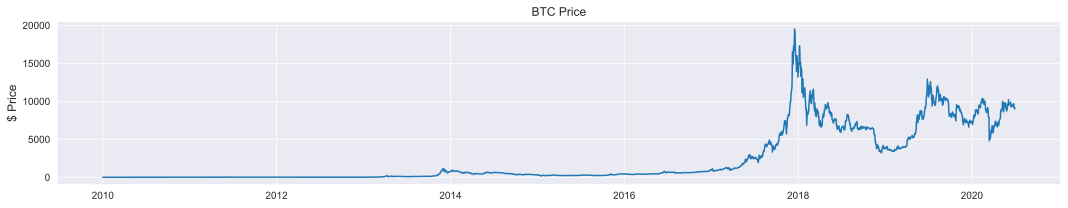

In [4]:
plt.figure(figsize=(18,3))
plt.title('BTC Price')
plt.ylabel('$ Price', fontsize = 12)
_ = plt.plot(btc_df)

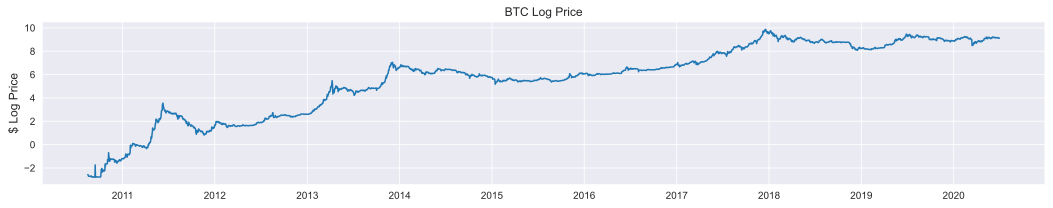

In [5]:
plt.figure(figsize=(18,3))
plt.title('BTC Log Price')
plt.ylabel('$ Log Price', fontsize = 12)
_ = plt.plot(np.log(btc_df))

Volume BTC  Miners Revenue
count  3.834000e+03  3.834000e+03  
mean   1.236565e+08  4.811773e+06  
std    3.098898e+08  7.297336e+06  
min    0.000000e+00  0.000000e+00  
25%    4.936460e+05  8.359008e+04  
50%    1.043787e+07  1.343535e+06  
75%    1.122199e+08  7.184973e+06  
max    5.352016e+09  5.319158e+07

Volume BTC  Miners Revenue
Missing %  0.0         0.0

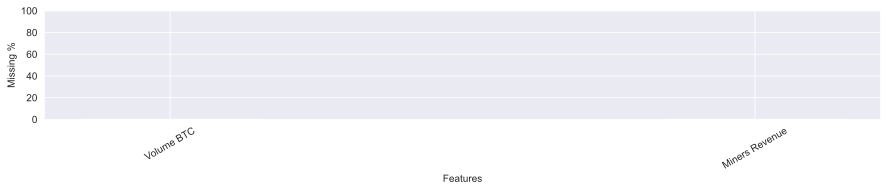

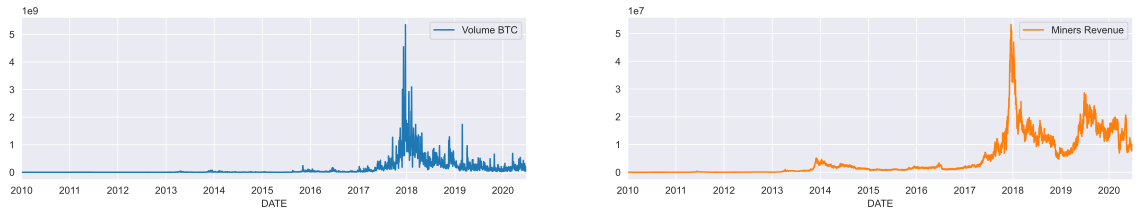

In [6]:
btc_tech = pd.read_csv('./Data/bitcoin_tech_data.csv',  index_col= 'DATE', parse_dates=['DATE'])
display(btc_tech.describe())
cal_perc_missing(btc_tech, figsize= (15,2), rotate_angle=30)
sub_plot(btc_tech)

### Equity Index Data

##### Here we have takem the daily level data for worlds largest indices across Asia, US and UK Subcontinent. Tha data is from 2010-2020. As we can see from the Missing % chart that there is no missing data for wekdays. Idea is there might be significant corelation bw the movent of BTC Price and various Equity Indices. 

In [7]:
equityIndicesData = pd.read_excel('Data/EquityIndicesData_PX_LAST.xlsx', index_col= 'DATE', parse_dates=['DATE'])

INDU Index    SPX Index    CCMP Index     NYA Index    UKX Index  \
count  2738.000000   2738.000000  2738.000000   2738.000000   2738.000000   
mean   17984.242367  2011.341804  4941.641363   10252.852597  6509.322787   
std    5337.036868   618.366550   2046.092540   1966.197401   720.162004    
min    9686.480000   1022.580000  2091.790000   6434.810000   4805.750000   
25%    13093.912500  1403.300000  3011.270000   8332.290000   5892.170000   
50%    17337.245000  2020.715000  4727.079500   10515.500000  6584.080000   
75%    22872.597500  2548.537500  6700.688000   11811.395000  7147.785000   
max    29551.420000  3386.150000  10131.370000  14183.200000  7877.450000   

        SX5E Index     NKY Index    TPX Index     HSI Index  SHSZ300 Index  
count  2738.000000  2738.000000   2738.000000  2738.000000   2738.000000    
mean   3058.715782  16053.060625  1285.038780  23831.668521  3178.997330    
std    408.871446   4971.113209   345.770678   3172.204362   640.180496     
min    1995.010000  8160.010000   695.510000   16250.270000  2086.970000    
25%    2774.520000  10453.872500  913.585000   21567.355000  2581.245000    
50%    3061.985000  16665.435000  1331.135000  23219.995000  3223.045000    
75%    3413.945000  20399.980000  1587.657500  26064.022500  3698.380000    
max    3865.180000  24270.620000  1911.070000  33154.120000  5353.750000

INDU Index  SPX Index  CCMP Index  NYA Index  UKX Index  \
Missing %  0.0         0.0        0.0         0.0        0.0         

           SX5E Index  NKY Index  TPX Index  HSI Index  SHSZ300 Index  
Missing %  0.0         0.0        0.0        0.0        0.0

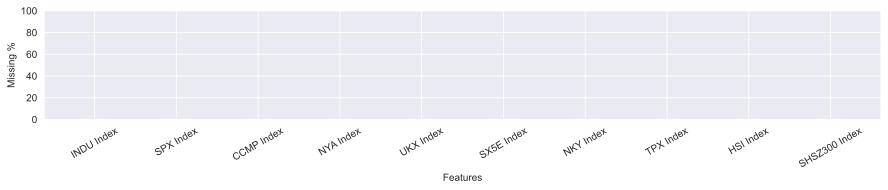

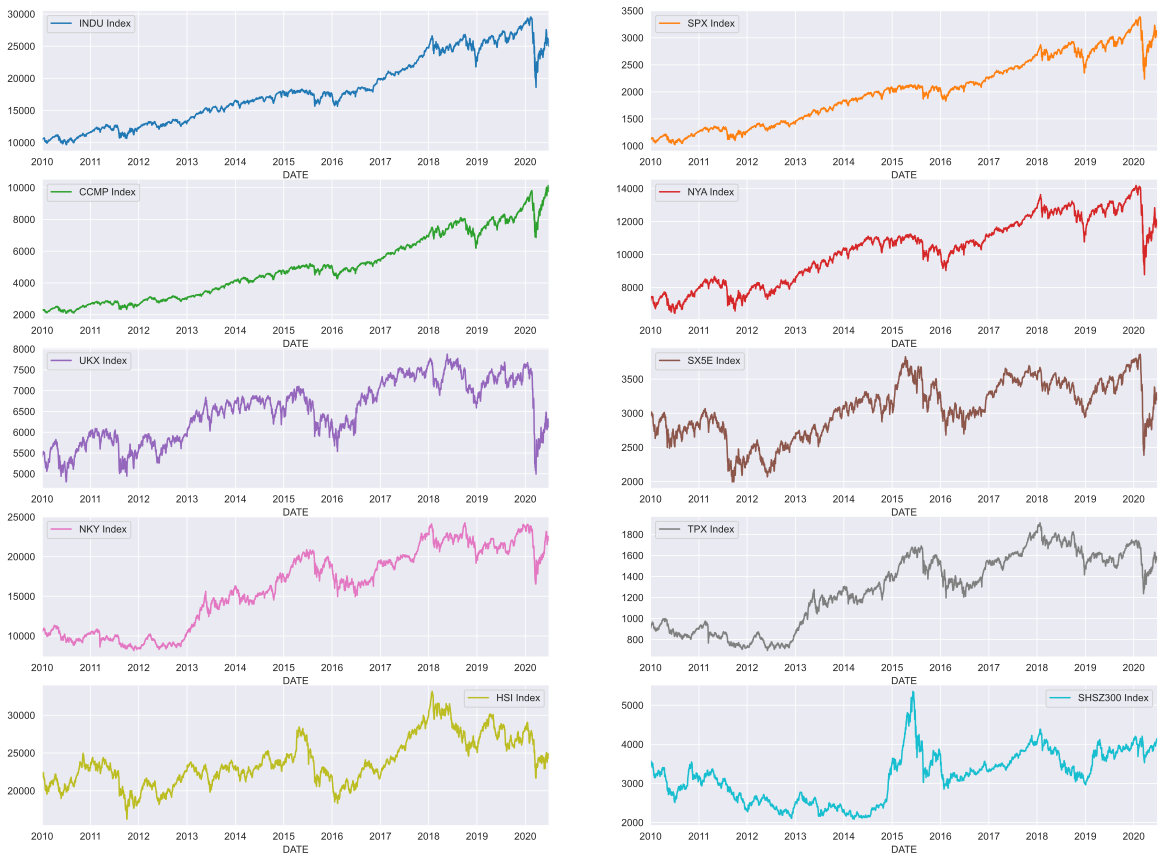

In [8]:
display(equityIndicesData.describe())
cal_perc_missing(equityIndicesData, figsize= (15,2), rotate_angle=30)
sub_plot(equityIndicesData)

### Commodities Data

##### Here we have take the daily level data for commodities like Gold, Silver, Crude Oil and Natural Gas along with Single commodity index. Tha data is from 2010-2020. As we can see from the Missing % chart that there is no missing data for wekdays. Idea is there might be significant corelation bw the movent of prices of BTC and various Commodity (and its indices) prices. 

###### One particular example of existing correlation b/w gold and BTC can be found here:  https://news.bitcoin.com/bitcoin-and-gold-correlation-reaches-record-high-70-bolstering-btcs-store-of-value-credentials/#:~:text=The%20prices%20of%20bitcoin%20and,the%20second%20quarter%20of%202020.

In [9]:
commoditiesData = pd.read_excel('Data/CommoditiesData_PX_LAST.xlsx', index_col= 'DATE', parse_dates=['DATE'])

BCOM Index   CL1 Comdty   NG1 Comdty   GC1 Comdty   SI1 Comdty
count  2738.000000  2738.000000  2738.000000  2738.000000  2738.000000
mean   110.090980   70.800442    3.233689     1361.438495  20.905349  
std    29.514443    22.913177    0.855591     187.385112   6.970854   
min    59.479500   -37.630000    1.482000     1050.800000  11.735000  
25%    83.716325    51.162500    2.652250     1227.300000  16.259750  
50%    101.612300   68.200000    3.037000     1301.750000  17.791500  
75%    135.784500   93.037500    3.894250     1497.075000  23.196000  
max    175.421100   113.930000   6.149000     1888.700000  48.584000

BCOM Index  CL1 Comdty  NG1 Comdty  GC1 Comdty  SI1 Comdty
Missing %  0.0         0.0         0.0         0.0         0.0

BCOM Index  CL1 Comdty  NG1 Comdty  GC1 Comdty  SI1 Comdty
DATE                                                                  
2010-01-01  139.1873    79.36       5.572       1096.2      16.845    
2010-01-04  142.3014    81.51       5.884       1118.3      17.463    
2010-01-05  142.1119    81.77       5.637       1118.7      17.800    
2010-01-06  145.0288    83.18       6.009       1136.5      18.175    
2010-01-07  142.8457    82.66       5.806       1133.7      18.345    
...              ...      ...         ...          ...         ...    
2020-06-24  63.7083     38.01       1.597       1765.8      17.670    
2020-06-25  63.4476     38.72       1.482       1762.1      17.895    
2020-06-26  63.2194     38.49       1.495       1772.5      18.035    
2020-06-29  64.2432     39.70       1.709       1781.2      17.980    
2020-06-30  64.9762     39.27       1.751       1800.5      18.541    

[2738 rows x 5 columns]

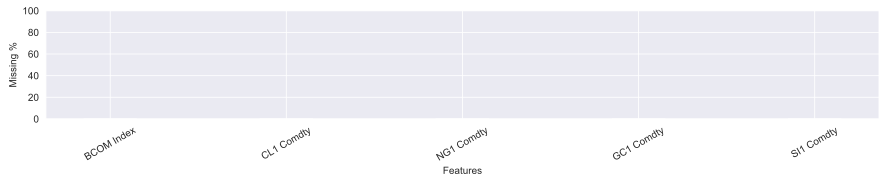

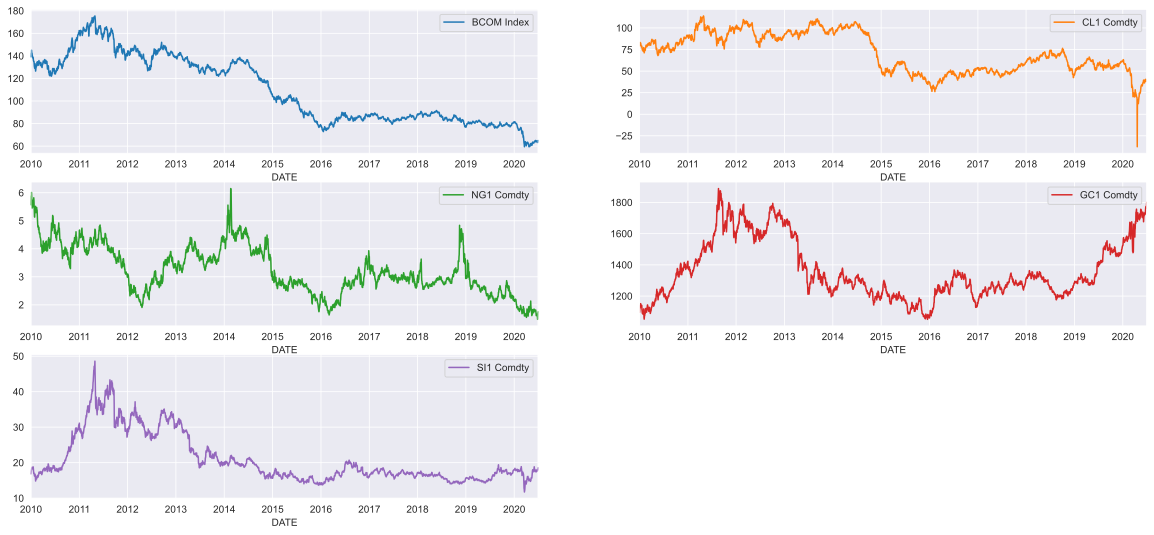

In [10]:
display(commoditiesData.describe())
cal_perc_missing(commoditiesData, figsize= (15,2), rotate_angle=30)
sub_plot(commoditiesData)
commoditiesData

### GDP Data

##### Here we have take the Q-o-Q level data for macro indicators in US and Asia. Tha data is from 2010-2020. As we can see from the Missing % chart that there is only one column having missing data for wekdays. Idea is there might be significant corelation bw the movent of proces of BTC and macro indicator data. 

In [11]:
macroData = pd.read_excel('Data/MacroData.xlsx', index_col= 'DATE', parse_dates=['DATE'])

CNGDPQOQ Index  GDP PIQQ Index  JGDPAGDP Index
Missing %  11.833          0.0             0.0

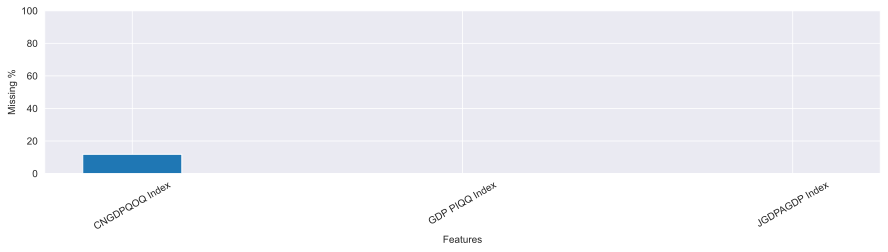

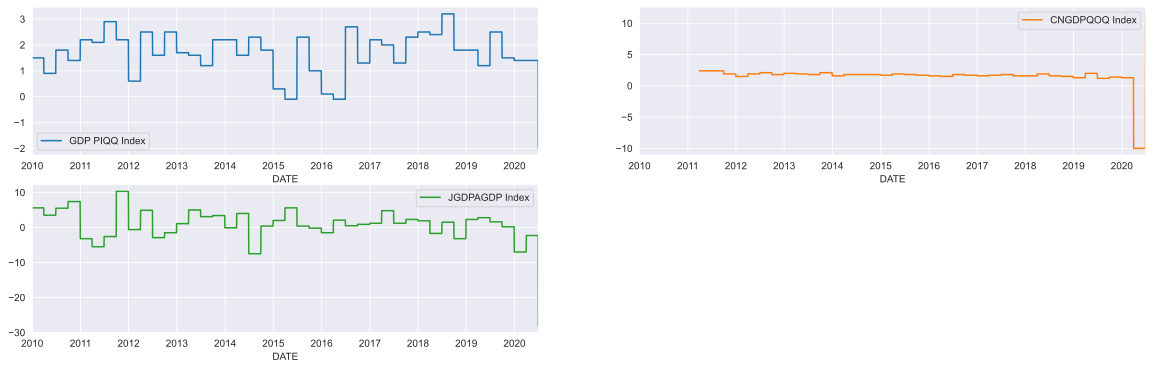

In [12]:
macroData.describe()
cal_perc_missing(macroData, figsize= (15,3), rotate_angle=30)
sub_plot(macroData)

### Alt Coins and Index Data

##### Here we have take the daily level data for Alt Coins like Eherium,Tether, XRP and their respective indices. Tha data is from 2010-2020.  Idea is there might be significant corelation bw the movent of proces of BTC and various AltCoin prices.

In [13]:
altCoinData = pd.read_excel('Data/AltCoinsAndIndicesData_PX_LAST.xlsx', index_col= 'DATE', parse_dates=['DATE'])

XETUSD Curncy  XRP Curncy  XLCUSD Curncy  XBNUSD Curncy   BGCI Index  \
count  624.000000     624.000000  624.000000     624.000000     760.000000    
mean   270.050048     0.374408    74.405239      441.069551     481.060566    
std    182.956486     0.185223    40.828317      333.800804     266.739157    
min    81.790000      0.138800    22.620000      76.820000      197.590000    
25%    157.751750     0.253625    45.163250      225.202500     307.435000    
50%    204.603500     0.315300    59.467500      312.255000     392.810000    
75%    283.275000     0.448950    88.986250      523.085000     543.937500    
max    936.642000     1.130600    243.740000     1668.320000    1667.360000   

         BITX Index    XAI Index  CRYPTO Index  
count  912.000000    1731.000000  653.000000    
mean   8517.898893   468.491752   1407.171424   
std    4698.100159   651.460956   585.857714    
min    796.770000    2.346000     1051.170000   
25%    5111.352500   5.947000     1153.450000   
50%    8451.510000   29.096000    1153.450000   
75%    10581.162500  718.295000   1273.400000   
max    27615.650000  3930.355000  4643.940000

XETUSD Curncy  XRP Curncy  XLCUSD Curncy  XBNUSD Curncy  \
Missing %  77.21          77.21       77.21          77.21           

           CRYPTO Index  BGCI Index  BITX Index  XAI Index  
Missing %  76.15         72.243      66.691      36.779

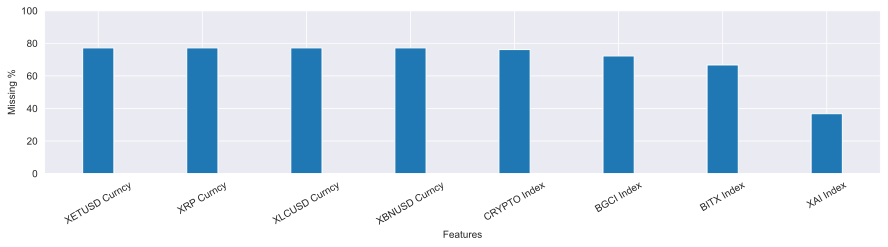

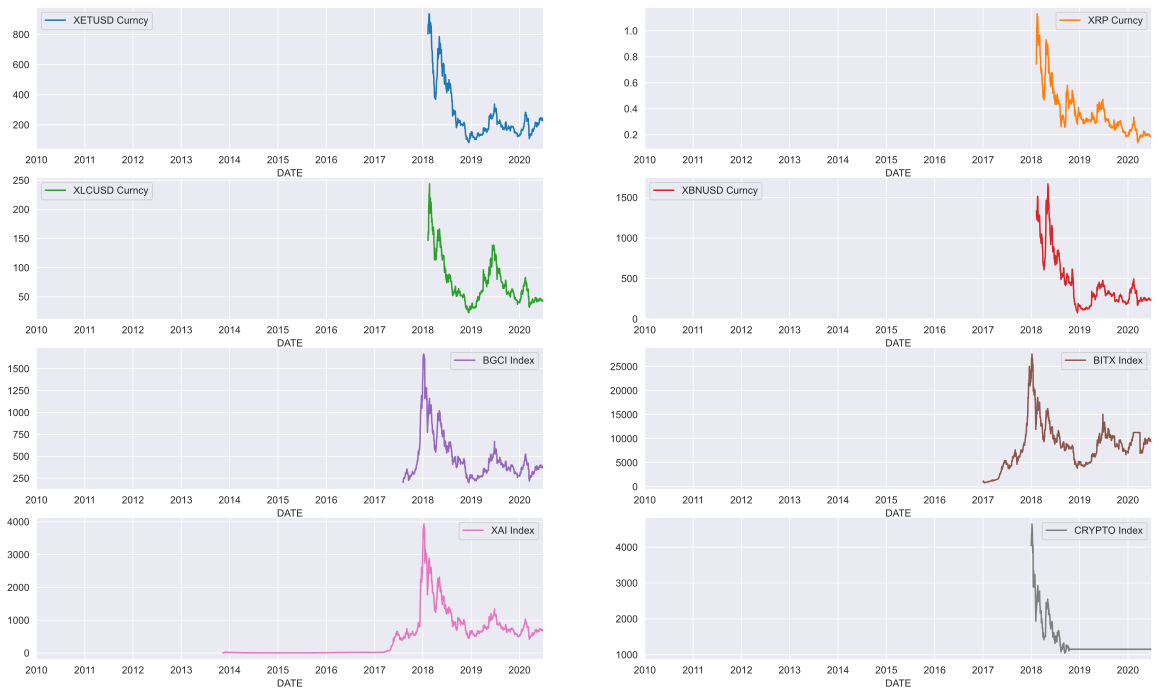

In [14]:
display(altCoinData.describe())
cal_perc_missing(altCoinData, figsize= (15,3), rotate_angle=30)
sub_plot(altCoinData)

##### Here we can see that for a large chunk of prospective Training Period (2010-2019), reliable data is not available for any of the AltCoins. Hence either we have to shorten the Training to period to significant level (~90%) for accomodating features extraced from this dataset or we can ignore them . As studies conducted by various research papers, one can see that BTC is largely resposible for creating movent in prices of AltCoins and not the other way around. Hence, it is better to exclude these resources from our final data set.

### Currency Pair Data

##### Here we have take the day  level data for major currency pairs across US, UK and Asia. Tha data is from 2010-2020. As we can see from the Missing % chart that there is no missing data for wekdays. Idea is there might be significant corelation bw the movent of prices of BTC and currency pairs.

In [15]:
currencyData = pd.read_excel('Data/CurrencyPairData_PX_LAST.xlsx', index_col= 'DATE', parse_dates=['DATE'])

EUR Curncy   JPY Curncy   GBP Curncy   CAD Curncy   AUD Curncy  \
count  2738.000000  2738.000000  2738.000000  2738.000000  2738.000000   
mean   1.224820     101.567184   1.463138     1.177215     0.847137      
std    0.114011     13.809672    0.146373     0.146827     0.131596      
min    1.038800     75.820000    1.148500     0.943300     0.574300      
25%    1.120100     89.717500    1.307700     1.026100     0.735800      
50%    1.214100     106.275000   1.517050     1.232250     0.794450      
75%    1.327850     111.457500   1.587000     1.315875     0.968300      
max    1.483000     125.630000   1.716600     1.457900     1.102000      

        NZD Curncy   CHF Curncy   DKK Curncy   NOK Curncy   SEK Curncy  \
count  2738.000000  2738.000000  2738.000000  2738.000000  2738.000000   
mean   0.737936     0.961607     6.136712     7.258311     7.845870      
std    0.069280     0.052302     0.563582     1.354015     1.128601      
min    0.570000     0.720900     5.028700     5.245400     6.014400      
25%    0.680925     0.930600     5.610975     5.925150     6.688425      
50%    0.727500     0.967000     6.130800     7.719800     8.073900      
75%    0.800500     0.992100     6.657700     8.425725     8.792925      
max    0.882300     1.163100     7.156700     11.705100    10.416700     

        SGD Curncy   KRW Curncy   TWD Curncy   ZAR Curncy   BRL Curncy  \
count  2738.000000  2738.000000  2738.000000  2738.000000  2738.000000   
mean   1.327279     1126.702823  30.586409    11.438478    2.854688      
std    0.063013     48.041014    1.070899     3.024067     0.947753      
min    1.200800     1008.550000  28.565000    6.568600     1.539100      
25%    1.265825     1090.875000  29.879250    8.391175     2.009975      
50%    1.346750     1126.375000  30.333500    11.800200    3.033850      
75%    1.376575     1158.592500  31.358500    14.001450    3.680150      
max    1.461000     1285.700000  33.787000    19.081500    5.887000      

        MXN Curncy  
count  2738.000000  
mean   15.913399    
std    3.228817     
min    11.495900    
25%    12.935325    
50%    15.193750    
75%    18.891125    
max    25.358800

EUR Curncy  JPY Curncy  GBP Curncy  CAD Curncy  AUD Curncy  \
Missing %  0.0         0.0         0.0         0.0         0.0          

           NZD Curncy  CHF Curncy  DKK Curncy  NOK Curncy  SEK Curncy  \
Missing %  0.0         0.0         0.0         0.0         0.0          

           SGD Curncy  KRW Curncy  TWD Curncy  ZAR Curncy  BRL Curncy  \
Missing %  0.0         0.0         0.0         0.0         0.0          

           MXN Curncy  
Missing %  0.0

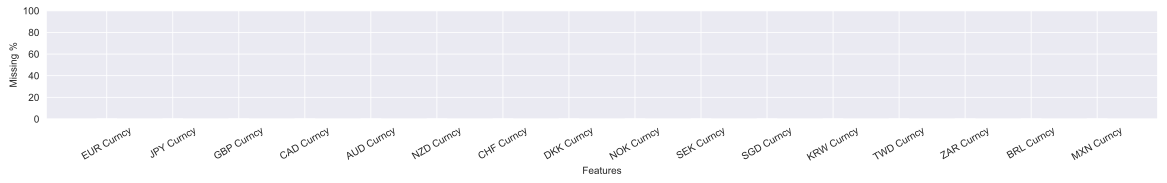

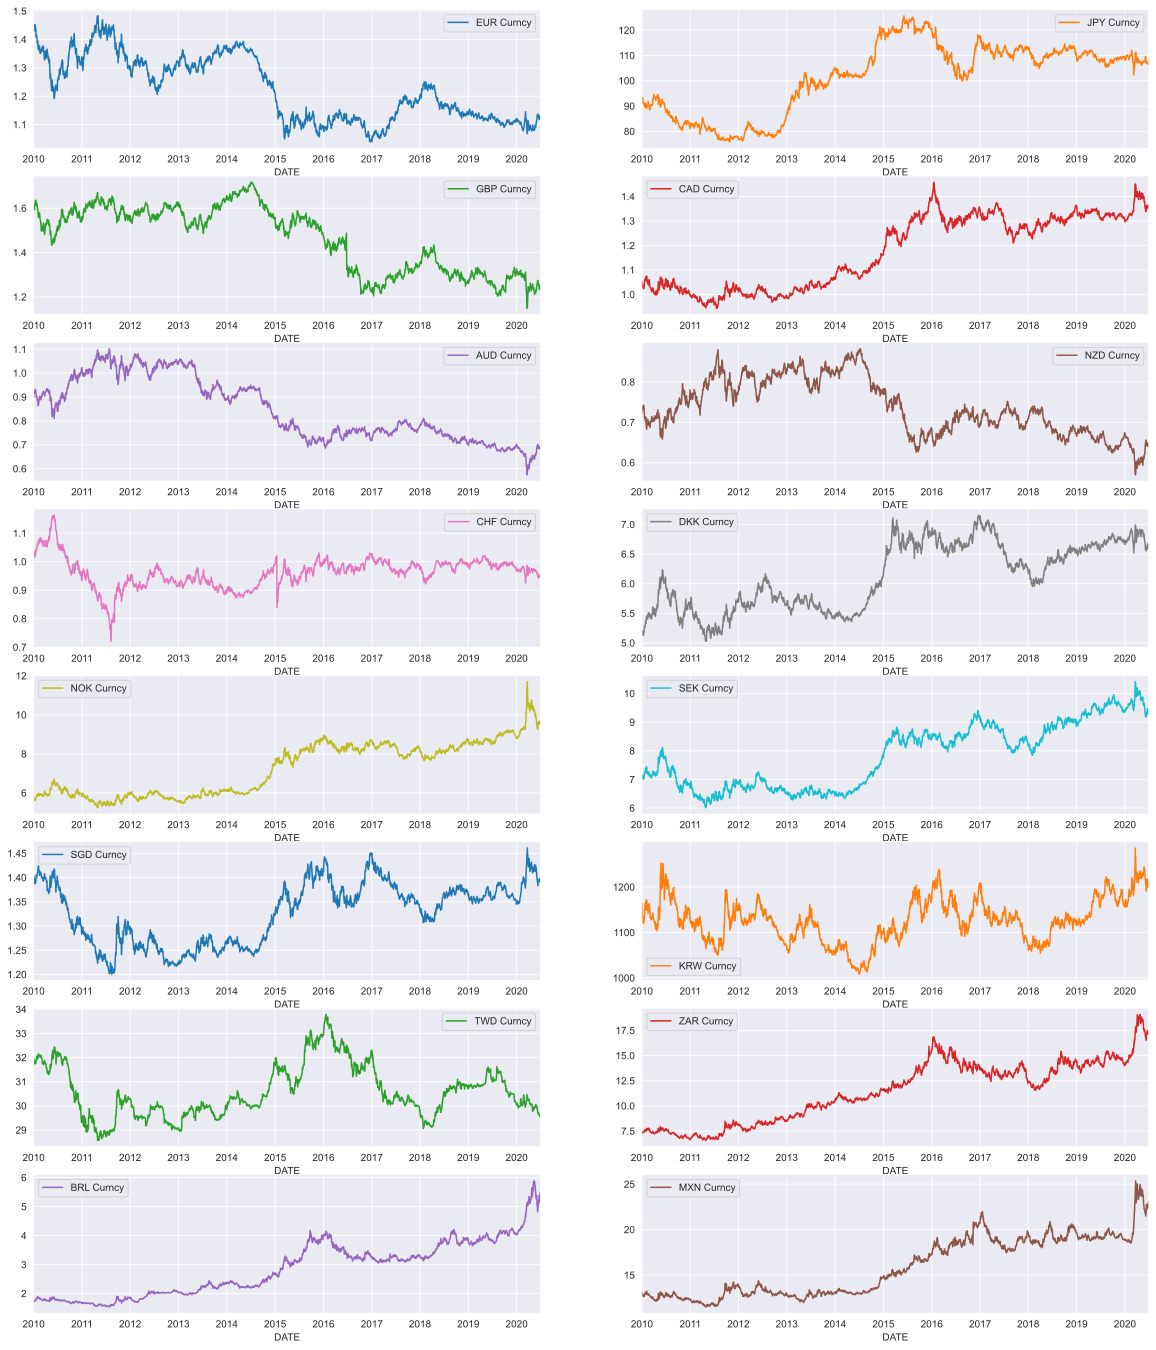

In [16]:
display(currencyData.describe())
cal_perc_missing(currencyData, figsize= (20,2), rotate_angle=30)
sub_plot(currencyData)

### Treasury Rate Data

##### Here we have take the day  level data for US Treasury Rates for 30Yr Data. Tha data is from 2010-2020. As we can see from the Missing % chart that there is no missing data for wekdays. Idea is there might be significant corelation bw the movent of prices of BTC and Treasury rates. When the rates then to dip, people tend to move their investment from safe instrument sot higher risky instruments in expectations of higher returns.

In [17]:
treasuryData = pd.read_excel('Data/TreasuryData30Year_PX_LAST.xlsx', index_col= 'DATE', parse_dates=['DATE'])

GB3 Govt     GB6 Govt    GB12 Govt     GT2 Govt     GT5 Govt  \
count  2738.000000  2738.000000  2738.000000  2738.000000  2738.000000   
mean   0.570119     0.645392     0.726054     0.939902     1.601787      
std    0.786294     0.800675     0.803062     0.748499     0.620078      
min   -0.088000     0.004000     0.064000     0.140000     0.274000      
25%    0.038000     0.089000     0.155000     0.346000     1.198000      
50%    0.129000     0.181500     0.273000     0.665500     1.597000      
75%    1.015500     1.119000     1.209000     1.341750     1.939750      
max    2.462000     2.563000     2.739000     2.967000     3.092000      

         GT10 Govt    GT30 Govt  
count  2738.000000  2738.000000  
mean   2.330574     3.114140     
std    0.620536     0.690576     
min    0.543000     0.997000     
25%    1.897000     2.760500     
50%    2.311500     3.025000     
75%    2.738000     3.428500     
max    3.988000     4.841000

GB3 Govt  GB6 Govt  GB12 Govt  GT2 Govt  GT5 Govt  GT10 Govt  \
Missing %  0.0       0.0       0.0        0.0       0.0       0.0         

           GT30 Govt  
Missing %  0.0

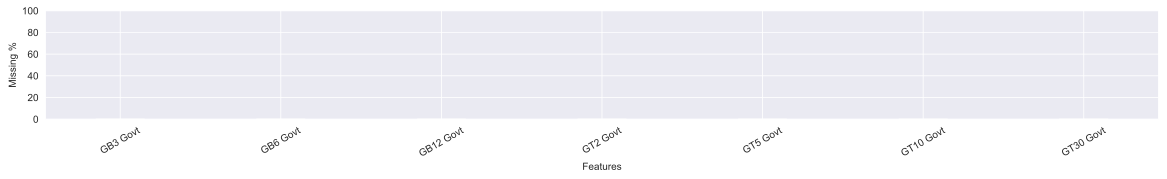

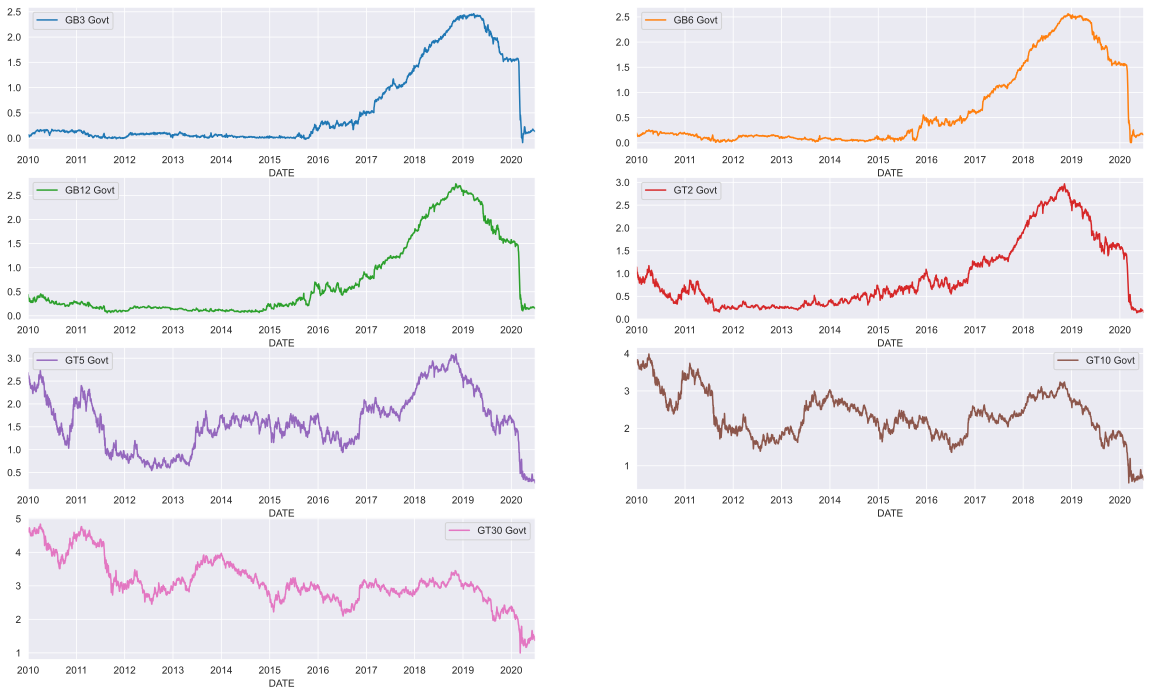

In [18]:
display(treasuryData.describe())
cal_perc_missing(treasuryData, figsize= (20,2), rotate_angle=30)
sub_plot(treasuryData)

### BTC volume data

In [19]:
btc_vol = quandl.get("BCHAIN/MWTRV", authtoken="wyd31EUH8vyE_pNRij3X")

In [20]:
btc_vol.columns = ['btcvol']

In [21]:
btc_vol = btc_vol.loc[(btc_vol.index >= '2010-01-01') & (btc_vol.index < '2020-06-30')]

## Part 2: Data Pre-processing for Models

##### Here we have left merged all the datasets created above with BTC Price in order to create a masters dataset.

In [22]:
dfList = [btc_tech, currencyData, altCoinData, equityIndicesData, commoditiesData, macroData, treasuryData, ]
df_final = btc_df.copy()
for i in dfList:   
    df_final = pd.concat([df_final, i], join='outer', axis = 1)  
df_final

BTCPrice    Volume BTC  Miners Revenue  EUR Curncy  JPY Curncy  \
2010-01-01  0.00      0.000000e+00  0.000           1.4324      93.04        
2010-01-02  0.00      0.000000e+00  0.000          NaN         NaN           
2010-01-03  0.00      0.000000e+00  0.000          NaN         NaN           
2010-01-04  0.00      0.000000e+00  0.000           1.4413      92.51        
2010-01-05  0.00      0.000000e+00  0.000           1.4365      91.72        
...          ...               ...    ...              ...        ...        
2020-06-26  9276.58   1.783659e+08  8504016.548     1.1219      107.22       
2020-06-27  9240.85   1.665311e+08  9950436.658    NaN         NaN           
2020-06-28  9154.45   1.417804e+08  8059992.059    NaN         NaN           
2020-06-29  9004.23   9.222168e+07  8666896.613     1.1242      107.58       
2020-06-30  9127.47   5.950152e+07  8562734.803     1.1234      107.93       

            GBP Curncy  CAD Curncy  AUD Curncy  NZD Curncy  CHF Curncy  ...  \
2010-01-01  1.6151      1.0528      0.8980      0.7231      1.0352      ...   
2010-01-02 NaN         NaN         NaN         NaN         NaN          ...   
2010-01-03 NaN         NaN         NaN         NaN         NaN          ...   
2010-01-04  1.6085      1.0416      0.9126      0.7344      1.0299      ...   
2010-01-05  1.5992      1.0390      0.9119      0.7346      1.0335      ...   
...            ...         ...         ...         ...         ...      ...   
2020-06-26  1.2336      1.3688      0.6865      0.6423      0.9477      ...   
2020-06-27 NaN         NaN         NaN         NaN         NaN          ...   
2020-06-28 NaN         NaN         NaN         NaN         NaN          ...   
2020-06-29  1.2298      1.3659      0.6866      0.6422      0.9512      ...   
2020-06-30  1.2401      1.3576      0.6903      0.6454      0.9473      ...   

            GDP PIQQ Index  CNGDPQOQ Index  JGDPAGDP Index  GB3 Govt  \
2010-01-01  1.5            NaN              5.6             0.061      
2010-01-02 NaN             NaN             NaN             NaN         
2010-01-03 NaN             NaN             NaN             NaN         
2010-01-04  1.5            NaN              5.6             0.060      
2010-01-05  1.5            NaN              5.6             0.066      
...         ...             ..              ...               ...      
2020-06-26  1.4            -10.0           -2.3             0.139      
2020-06-27 NaN             NaN             NaN             NaN         
2020-06-28 NaN             NaN             NaN             NaN         
2020-06-29  1.4            -10.0           -2.3             0.131      
2020-06-30 -2.0             11.5           -28.1            0.139      

            GB6 Govt  GB12 Govt  GT2 Govt  GT5 Govt  GT10 Govt  GT30 Govt  
2010-01-01  0.192     0.440      1.140     2.681     3.837      4.629      
2010-01-02 NaN       NaN        NaN       NaN       NaN        NaN         
2010-01-03 NaN       NaN        NaN       NaN       NaN        NaN         
2010-01-04  0.175     0.405      1.068     2.637     3.817      4.644      
2010-01-05  0.157     0.374      1.012     2.563     3.763      4.610      
...           ...       ...        ...       ...       ...        ...      
2020-06-26  0.164     0.159      0.167     0.303     0.642      1.371      
2020-06-27 NaN       NaN        NaN       NaN       NaN        NaN         
2020-06-28 NaN       NaN        NaN       NaN       NaN        NaN         
2020-06-29  0.160     0.151      0.150     0.274     0.624      1.374      
2020-06-30  0.160     0.154      0.150     0.289     0.657      1.412      

[3834 rows x 52 columns]

XBNUSD Curncy  XLCUSD Curncy  XRP Curncy  XETUSD Curncy  \
Missing %  83.725         83.725         83.725      83.725          

           CRYPTO Index  BGCI Index  BITX Index  XAI Index  CNGDPQOQ Index  \
Missing %  82.968        80.177      76.213      54.851     37.037           

           BCOM Index  ...  SGD Curncy  KRW Curncy  TWD Curncy  ZAR Curncy  \
Missing %  28.586      ...  28.586      28.586      28.586      28.586       

           BRL Curncy  MXN Curncy  INDU Index  Volume BTC  Miners Revenue  \
Missing %  28.586      28.586      28.586      0.0         0.0              

           BTCPrice  
Missing %  0.0       

[1 rows x 52 columns]

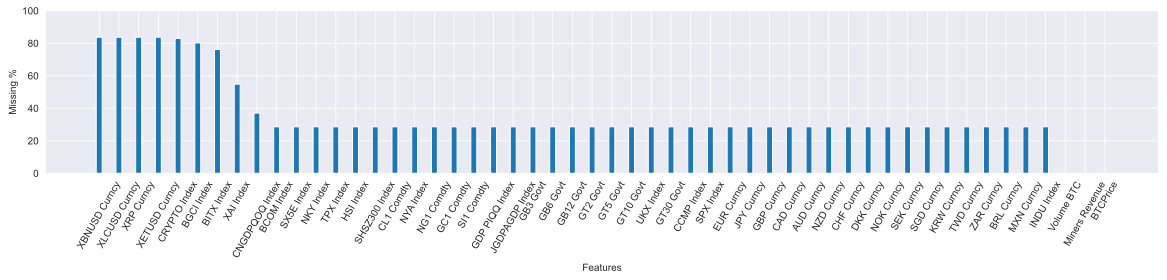

In [23]:
cal_perc_missing(df_final, figsize= (20,3), rotate_angle=60)

###### Here as expected we can see missing percentages for all the variables for weekend days, as BTC gets traded on weekends but not th rest of securities, along with few other variables where data is missing for weekdays largely AltCoins Data.Here we are creating a new variable in the master dataset for day of the week and forward filling data for weekends i.e Friday closing data for Saturday & Sunday.

In [24]:
df_final['dayOfWeek'] = pd.DatetimeIndex(df_final.index).dayofweek
df_final

BTCPrice    Volume BTC  Miners Revenue  EUR Curncy  JPY Curncy  \
2010-01-01  0.00      0.000000e+00  0.000           1.4324      93.04        
2010-01-02  0.00      0.000000e+00  0.000          NaN         NaN           
2010-01-03  0.00      0.000000e+00  0.000          NaN         NaN           
2010-01-04  0.00      0.000000e+00  0.000           1.4413      92.51        
2010-01-05  0.00      0.000000e+00  0.000           1.4365      91.72        
...          ...               ...    ...              ...        ...        
2020-06-26  9276.58   1.783659e+08  8504016.548     1.1219      107.22       
2020-06-27  9240.85   1.665311e+08  9950436.658    NaN         NaN           
2020-06-28  9154.45   1.417804e+08  8059992.059    NaN         NaN           
2020-06-29  9004.23   9.222168e+07  8666896.613     1.1242      107.58       
2020-06-30  9127.47   5.950152e+07  8562734.803     1.1234      107.93       

            GBP Curncy  CAD Curncy  AUD Curncy  NZD Curncy  CHF Curncy  ...  \
2010-01-01  1.6151      1.0528      0.8980      0.7231      1.0352      ...   
2010-01-02 NaN         NaN         NaN         NaN         NaN          ...   
2010-01-03 NaN         NaN         NaN         NaN         NaN          ...   
2010-01-04  1.6085      1.0416      0.9126      0.7344      1.0299      ...   
2010-01-05  1.5992      1.0390      0.9119      0.7346      1.0335      ...   
...            ...         ...         ...         ...         ...      ...   
2020-06-26  1.2336      1.3688      0.6865      0.6423      0.9477      ...   
2020-06-27 NaN         NaN         NaN         NaN         NaN          ...   
2020-06-28 NaN         NaN         NaN         NaN         NaN          ...   
2020-06-29  1.2298      1.3659      0.6866      0.6422      0.9512      ...   
2020-06-30  1.2401      1.3576      0.6903      0.6454      0.9473      ...   

            CNGDPQOQ Index  JGDPAGDP Index  GB3 Govt  GB6 Govt  GB12 Govt  \
2010-01-01 NaN              5.6             0.061     0.192     0.440       
2010-01-02 NaN             NaN             NaN       NaN       NaN          
2010-01-03 NaN             NaN             NaN       NaN       NaN          
2010-01-04 NaN              5.6             0.060     0.175     0.405       
2010-01-05 NaN              5.6             0.066     0.157     0.374       
...         ..              ...               ...       ...       ...       
2020-06-26 -10.0           -2.3             0.139     0.164     0.159       
2020-06-27 NaN             NaN             NaN       NaN       NaN          
2020-06-28 NaN             NaN             NaN       NaN       NaN          
2020-06-29 -10.0           -2.3             0.131     0.160     0.151       
2020-06-30  11.5           -28.1            0.139     0.160     0.154       

            GT2 Govt  GT5 Govt  GT10 Govt  GT30 Govt  dayOfWeek  
2010-01-01  1.140     2.681     3.837      4.629      4          
2010-01-02 NaN       NaN       NaN        NaN         5          
2010-01-03 NaN       NaN       NaN        NaN         6          
2010-01-04  1.068     2.637     3.817      4.644      0          
2010-01-05  1.012     2.563     3.763      4.610      1          
...           ...       ...       ...        ...     ..          
2020-06-26  0.167     0.303     0.642      1.371      4          
2020-06-27 NaN       NaN       NaN        NaN         5          
2020-06-28 NaN       NaN       NaN        NaN         6          
2020-06-29  0.150     0.274     0.624      1.374      0          
2020-06-30  0.150     0.289     0.657      1.412      1          

[3834 rows x 53 columns]

In [25]:
df_final[df_final['dayOfWeek'].isin([4,5,6])]

BTCPrice    Volume BTC  Miners Revenue  EUR Curncy  JPY Curncy  \
2010-01-01  0.00      0.000000e+00  0.000           1.4324      93.04        
2010-01-02  0.00      0.000000e+00  0.000          NaN         NaN           
2010-01-03  0.00      0.000000e+00  0.000          NaN         NaN           
2010-01-08  0.00      0.000000e+00  0.000           1.4409      92.66        
2010-01-09  0.00      0.000000e+00  0.000          NaN         NaN           
...          ...               ...    ...           ..          ..           
2020-06-20  9380.03   7.404174e+07  8736099.478    NaN         NaN           
2020-06-21  9300.15   1.097328e+08  8238014.002    NaN         NaN           
2020-06-26  9276.58   1.783659e+08  8504016.548     1.1219      107.22       
2020-06-27  9240.85   1.665311e+08  9950436.658    NaN         NaN           
2020-06-28  9154.45   1.417804e+08  8059992.059    NaN         NaN           

            GBP Curncy  CAD Curncy  AUD Curncy  NZD Curncy  CHF Curncy  ...  \
2010-01-01  1.6151      1.0528      0.8980      0.7231      1.0352      ...   
2010-01-02 NaN         NaN         NaN         NaN         NaN          ...   
2010-01-03 NaN         NaN         NaN         NaN         NaN          ...   
2010-01-08  1.6023      1.0298      0.9248      0.7366      1.0237      ...   
2010-01-09 NaN         NaN         NaN         NaN         NaN          ...   
...         ..          ..          ..          ..          ..          ...   
2020-06-20 NaN         NaN         NaN         NaN         NaN          ...   
2020-06-21 NaN         NaN         NaN         NaN         NaN          ...   
2020-06-26  1.2336      1.3688      0.6865      0.6423      0.9477      ...   
2020-06-27 NaN         NaN         NaN         NaN         NaN          ...   
2020-06-28 NaN         NaN         NaN         NaN         NaN          ...   

            CNGDPQOQ Index  JGDPAGDP Index  GB3 Govt  GB6 Govt  GB12 Govt  \
2010-01-01 NaN              5.6             0.061     0.192     0.440       
2010-01-02 NaN             NaN             NaN       NaN       NaN          
2010-01-03 NaN             NaN             NaN       NaN       NaN          
2010-01-08 NaN              5.6             0.045     0.150     0.330       
2010-01-09 NaN             NaN             NaN       NaN       NaN          
...         ..              ..              ..        ..        ..          
2020-06-20 NaN             NaN             NaN       NaN       NaN          
2020-06-21 NaN             NaN             NaN       NaN       NaN          
2020-06-26 -10.0           -2.3             0.139     0.164     0.159       
2020-06-27 NaN             NaN             NaN       NaN       NaN          
2020-06-28 NaN             NaN             NaN       NaN       NaN          

            GT2 Govt  GT5 Govt  GT10 Govt  GT30 Govt  dayOfWeek  
2010-01-01  1.140     2.681     3.837      4.629      4          
2010-01-02 NaN       NaN       NaN        NaN         5          
2010-01-03 NaN       NaN       NaN        NaN         6          
2010-01-08  0.980     2.593     3.832      4.716      4          
2010-01-09 NaN       NaN       NaN        NaN         5          
...         ..        ..        ..         ..        ..          
2020-06-20 NaN       NaN       NaN        NaN         5          
2020-06-21 NaN       NaN       NaN        NaN         6          
2020-06-26  0.167     0.303     0.642      1.371      4          
2020-06-27 NaN       NaN       NaN        NaN         5          
2020-06-28 NaN       NaN       NaN        NaN         6          

[1644 rows x 53 columns]

In [26]:
df_final[df_final['dayOfWeek'].isin([4,5,6])] = df_final[df_final['dayOfWeek'].isin([4,5,6])].ffill(axis =0)

XBNUSD Curncy  XLCUSD Curncy  XRP Curncy  XETUSD Curncy  \
Missing %  77.204         77.204         77.204      77.204          

           CRYPTO Index  BGCI Index  BITX Index  XAI Index  CNGDPQOQ Index  \
Missing %  76.135        72.248      66.719      36.802     11.841           

           BCOM Index  ...  SEK Curncy  SGD Curncy  KRW Curncy  TWD Curncy  \
Missing %  0.0         ...  0.0         0.0         0.0         0.0          

           ZAR Curncy  BRL Curncy  MXN Curncy  Volume BTC  INDU Index  \
Missing %  0.0         0.0         0.0         0.0         0.0          

           dayOfWeek  
Missing %  0.0        

[1 rows x 53 columns]

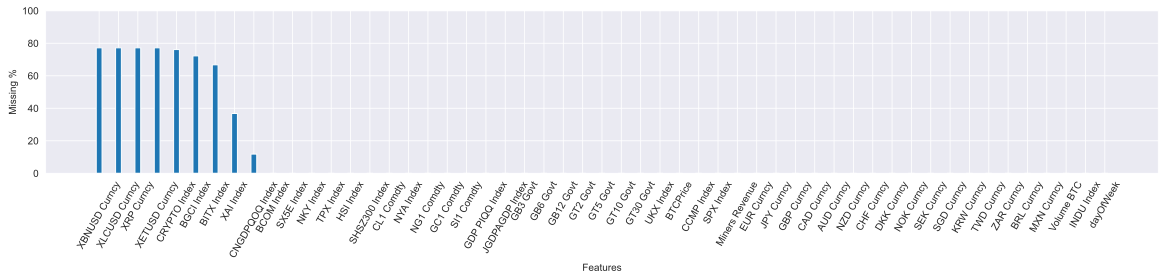

In [27]:
cal_perc_missing(df_final, figsize= (20,3), rotate_angle=60)

##### Removing all those variable for which we dont have 100% of data from the masters dataset.

In [28]:
df_final = df_final.dropna(axis =1)
df_final

BTCPrice    Volume BTC  Miners Revenue  EUR Curncy  JPY Curncy  \
2010-01-01  0.00      0.000000e+00  0.000           1.4324      93.04        
2010-01-02  0.00      0.000000e+00  0.000           1.4324      93.04        
2010-01-03  0.00      0.000000e+00  0.000           1.4324      93.04        
2010-01-04  0.00      0.000000e+00  0.000           1.4413      92.51        
2010-01-05  0.00      0.000000e+00  0.000           1.4365      91.72        
...          ...               ...    ...              ...        ...        
2020-06-26  9276.58   1.783659e+08  8504016.548     1.1219      107.22       
2020-06-27  9240.85   1.665311e+08  9950436.658     1.1219      107.22       
2020-06-28  9154.45   1.417804e+08  8059992.059     1.1219      107.22       
2020-06-29  9004.23   9.222168e+07  8666896.613     1.1242      107.58       
2020-06-30  9127.47   5.950152e+07  8562734.803     1.1234      107.93       

            GBP Curncy  CAD Curncy  AUD Curncy  NZD Curncy  CHF Curncy  ...  \
2010-01-01  1.6151      1.0528      0.8980      0.7231      1.0352      ...   
2010-01-02  1.6151      1.0528      0.8980      0.7231      1.0352      ...   
2010-01-03  1.6151      1.0528      0.8980      0.7231      1.0352      ...   
2010-01-04  1.6085      1.0416      0.9126      0.7344      1.0299      ...   
2010-01-05  1.5992      1.0390      0.9119      0.7346      1.0335      ...   
...            ...         ...         ...         ...         ...      ...   
2020-06-26  1.2336      1.3688      0.6865      0.6423      0.9477      ...   
2020-06-27  1.2336      1.3688      0.6865      0.6423      0.9477      ...   
2020-06-28  1.2336      1.3688      0.6865      0.6423      0.9477      ...   
2020-06-29  1.2298      1.3659      0.6866      0.6422      0.9512      ...   
2020-06-30  1.2401      1.3576      0.6903      0.6454      0.9473      ...   

            GDP PIQQ Index  JGDPAGDP Index  GB3 Govt  GB6 Govt  GB12 Govt  \
2010-01-01  1.5             5.6             0.061     0.192     0.440       
2010-01-02  1.5             5.6             0.061     0.192     0.440       
2010-01-03  1.5             5.6             0.061     0.192     0.440       
2010-01-04  1.5             5.6             0.060     0.175     0.405       
2010-01-05  1.5             5.6             0.066     0.157     0.374       
...         ...             ...               ...       ...       ...       
2020-06-26  1.4            -2.3             0.139     0.164     0.159       
2020-06-27  1.4            -2.3             0.139     0.164     0.159       
2020-06-28  1.4            -2.3             0.139     0.164     0.159       
2020-06-29  1.4            -2.3             0.131     0.160     0.151       
2020-06-30 -2.0            -28.1            0.139     0.160     0.154       

            GT2 Govt  GT5 Govt  GT10 Govt  GT30 Govt  dayOfWeek  
2010-01-01  1.140     2.681     3.837      4.629      4          
2010-01-02  1.140     2.681     3.837      4.629      5          
2010-01-03  1.140     2.681     3.837      4.629      6          
2010-01-04  1.068     2.637     3.817      4.644      0          
2010-01-05  1.012     2.563     3.763      4.610      1          
...           ...       ...       ...        ...     ..          
2020-06-26  0.167     0.303     0.642      1.371      4          
2020-06-27  0.167     0.303     0.642      1.371      5          
2020-06-28  0.167     0.303     0.642      1.371      6          
2020-06-29  0.150     0.274     0.624      1.374      0          
2020-06-30  0.150     0.289     0.657      1.412      1          

[3834 rows x 44 columns]

In [29]:
full_df = df_final.copy()

In [49]:
full_df.columns

Index(['BTCPrice', 'Volume BTC', 'Miners Revenue', 'EUR Curncy', 'JPY Curncy',
       'GBP Curncy', 'CAD Curncy', 'AUD Curncy', 'NZD Curncy', 'CHF Curncy',
       'DKK Curncy', 'NOK Curncy', 'SEK Curncy', 'SGD Curncy', 'KRW Curncy',
       'TWD Curncy', 'ZAR Curncy', 'BRL Curncy', 'MXN Curncy', 'INDU Index',
       'SPX Index', 'CCMP Index', 'NYA Index', 'UKX Index', 'SX5E Index',
       'NKY Index', 'TPX Index', 'HSI Index', 'SHSZ300 Index', 'BCOM Index',
       'CL1 Comdty', 'NG1 Comdty', 'GC1 Comdty', 'SI1 Comdty',
       'GDP PIQQ Index', 'JGDPAGDP Index', 'GB3 Govt', 'GB6 Govt', 'GB12 Govt',
       'GT2 Govt', 'GT5 Govt', 'GT10 Govt', 'GT30 Govt', 'dayOfWeek'],
      dtype='object')

In [50]:
selected_columns = ['BTCPrice', 'Volume BTC','GBP Curncy', 'CAD Curncy',
       'SPX Index', 'TPX Index', 'BCOM Index','GC1 Comdty','GB3 Govt','GT30 Govt', 'dayOfWeek']

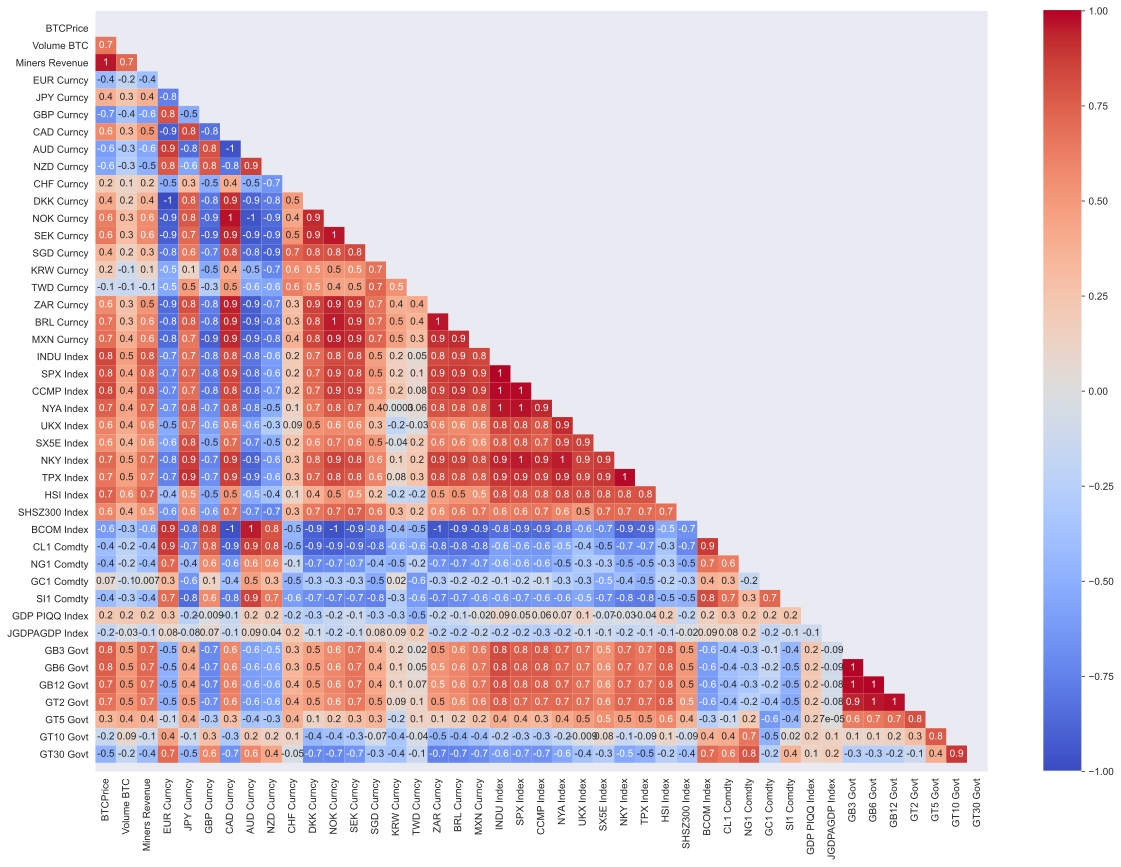

In [48]:
heatmap(df = full_df.iloc[:, :-1], shape = (20,14), annot=True)

##### As we can see from the above heatmap, there is significant correlation with the all the feaures and BTC price. Hence, we can use some of these features for the prediction of BTC Price going ahead.
##### Below we are splitting the data set to so that we can normalize the data set following the process as described below.

### Our approach to Normalization

##### 1) Given the price of the BTC was moving exponentially, we have transformed to log-linear scale. 

##### 2) 'GDP PIQQ Index', 'dayOfWeek' and  'JGDPAGDP Index'  variabels have been untouched as few of them indicate the day of the week and rest of them are Y-O-Y change.

##### 3) Given we are looking back to 28 days for making prediction of price for next seven days, we have decided to Z-scale all the signals except for the 4 discussed above to normalize using Z-Scale transformation. This will allow us to bring all the variables to same scale and alos push gradient descent to converge fast. Conventionally we could have use other ways to normlaize the whole columns at once using some scale, but that would risk of information leakage.

In [31]:
full_df_2015 = full_df[full_df.index >= '2015-01-01']

L1 = ['BTCPrice', 'GDP PIQQ Index', 'dayOfWeek', 'JGDPAGDP Index'] 
L2 = set(full_df_2015.columns) - set(L1)

full_df_2015_1 = full_df_2015[L1]
full_df_2015_2 = full_df_2015[L2]

In [32]:
full_df_2015_1['BTCPrice'] = np.log(full_df_2015_1['BTCPrice'])
full_df_2015_1

BTCPrice  GDP PIQQ Index  dayOfWeek  JGDPAGDP Index
2015-01-01  5.754792  0.3             3          2.0           
2015-01-02  5.756217  0.3             4          2.0           
2015-01-03  5.711519  0.3             5          2.0           
2015-01-04  5.601860  0.3             6          2.0           
2015-01-05  5.623295  0.3             0          2.0           
...              ...  ...            ..          ...           
2020-06-26  9.135248  1.4             4         -2.3           
2020-06-27  9.131389  1.4             5         -2.3           
2020-06-28  9.121995  1.4             6         -2.3           
2020-06-29  9.105450  1.4             0         -2.3           
2020-06-30  9.119044 -2.0             1         -28.1          

[2008 rows x 4 columns]

In [33]:
mn = full_df_2015_2[-28:].mean()
std = full_df_2015_2[-28:].std()
lastVal = full_df_2015_2[-1:]
(lastVal-mn)/std

CHF Curncy  CAD Curncy  SGD Curncy  GC1 Comdty  GB6 Govt  \
2020-06-30 -0.809366    0.199853    0.124692    1.979862   -1.57923    

            HSI Index  NG1 Comdty  DKK Curncy  GBP Curncy  SI1 Comdty  ...  \
2020-06-30 -0.485322   0.622212    0.433336   -0.806245    2.843983    ...   

            SPX Index  SX5E Index  Volume BTC  GT2 Govt  EUR Curncy  \
2020-06-30 -0.022719  -0.224124   -0.966465   -2.266699 -0.500041     

            INDU Index  JPY Curncy  CCMP Index  GB12 Govt  CL1 Comdty  
2020-06-30 -0.329637    0.343542    1.31684    -1.996552   0.583315    

[1 rows x 40 columns]

In [34]:
## Function to normalized daata sets in period of lookback_days (here 28)

normalized_df_2015 = []
lookback_days  = 28

for i in range(lookback_days, full_df_2015_2.shape[0]+1):    
    normalized_df_2015.append(z_scaling(full_df_2015_2[i-lookback_days:i]).iloc[-1])

normalized_df_2015 = pd.DataFrame(normalized_df_2015)
normalized_df_2015

CHF Curncy  CAD Curncy  SGD Curncy  GC1 Comdty  GB6 Govt  \
2015-01-28 -0.537528    1.862783    2.642123    0.931253   -0.356850   
2015-01-29 -0.236773    1.969134    2.423323    0.115648   -1.099109   
2015-01-30 -0.250125    2.109452    2.163162    0.669510   -2.122512   
2015-01-31 -0.211174    1.896011    1.927578    0.616573   -2.051338   
2015-02-01 -0.171314    1.725956    1.741846    0.564978   -2.049003   
...              ...         ...         ...         ...         ...   
2020-06-26 -0.942231    1.257292   -0.282056    1.658489   -1.171180   
2020-06-27 -0.878449    1.370148   -0.206538    1.538511   -1.191811   
2020-06-28 -0.818443    1.506920   -0.105858    1.434302   -1.213118   
2020-06-29 -0.169800    1.123067    0.012685    1.598866   -1.683863   
2020-06-30 -0.809366    0.199853    0.124692    1.979862   -1.579230   

            HSI Index  NG1 Comdty  DKK Curncy  GBP Curncy  SI1 Comdty  ...  \
2015-01-28  1.623617  -1.002516    1.386214   -0.217117    1.006280    ...   
2015-01-29  0.943783  -2.111670    1.167148   -0.864513   -0.480322    ...   
2015-01-30  0.684205  -2.064245    1.200137   -0.891566   -0.047179    ...   
2015-01-31  0.633605  -1.848118    1.123902   -0.852950   -0.115960    ...   
2015-02-01  0.584260  -1.675001    1.055790   -0.830308   -0.196474    ...   
...              ...        ...         ...         ...         ...    ...   
2020-06-26  0.269956  -2.251004    0.282134   -1.468151    0.526744    ...   
2020-06-27  0.191995  -2.022233    0.377978   -1.461971    0.611266    ...   
2020-06-28  0.084595  -1.844418    0.501452   -1.455844    0.713167    ...   
2020-06-29 -0.834751   0.206671    0.212258   -1.611168    0.818591    ...   
2020-06-30 -0.485322   0.622212    0.433336   -0.806245    2.843983    ...   

            SPX Index  SX5E Index  Volume BTC  GT2 Govt  EUR Curncy  \
2015-01-28 -1.583527   1.322794   -0.703282   -1.082832 -1.357905     
2015-01-29 -0.603798   1.317222   -0.010589   -0.327876 -1.165841     
2015-01-30 -1.735975   1.084507   -0.524180   -1.231555 -1.191476     
2015-01-31 -1.598169   1.012533   -0.959619   -1.181241 -1.117987     
2015-02-01 -1.482608   0.945869   -0.708790   -1.149670 -1.052858     
...              ...        ...         ...         ...       ...     
2020-06-26 -1.504850  -0.283153    0.360793   -1.419365 -0.369031     
2020-06-27 -1.448744  -0.366448    0.234940   -1.448724 -0.466645     
2020-06-28 -1.396614  -0.468496   -0.054348   -1.479382 -0.591631     
2020-06-29 -0.724674  -0.209668   -0.614336   -2.435355 -0.283210     
2020-06-30 -0.022719  -0.224124   -0.966465   -2.266699 -0.500041     

            INDU Index  JPY Curncy  CCMP Index  GB12 Govt  CL1 Comdty  
2015-01-28 -2.360587   -0.831223   -0.859282   -1.024548  -1.496131    
2015-01-29 -1.018355   -0.084240    0.010660   -0.954681  -1.412099    
2015-01-30 -2.168467   -0.809158   -0.829354   -1.202532   0.300257    
2015-01-31 -1.958696   -0.773655   -0.771002   -1.128772   0.426651    
2015-02-01 -1.793712   -0.756367   -0.715050   -1.063659   0.613247    
...              ...         ...         ...         ...        ...    
2020-06-26 -1.534328   -0.499578   -0.189532   -2.222034   0.264952    
2020-06-27 -1.478753   -0.474348   -0.251125   -2.058161   0.207805    
2020-06-28 -1.427068   -0.449570   -0.321141   -1.920292   0.145366    
2020-06-29 -0.628905   -0.065474    0.300730   -2.566552   0.966038    
2020-06-30 -0.329637    0.343542    1.316840   -1.996552   0.583315    

[1981 rows x 40 columns]

In [35]:
## Merging the final data set again.
full_df_merged = full_df_2015_1.merge(normalized_df_2015, right_index=True, left_index=True)
full_df_merged

BTCPrice  GDP PIQQ Index  dayOfWeek  JGDPAGDP Index  CHF Curncy  \
2015-01-28  5.518456  0.3             2          2.0            -0.537528     
2015-01-29  5.451854  0.3             3          2.0            -0.236773     
2015-01-30  5.438557  0.3             4          2.0            -0.250125     
2015-01-31  5.436774  0.3             5          2.0            -0.211174     
2015-02-01  5.396895  0.3             6          2.0            -0.171314     
...              ...  ...            ..          ...                  ...     
2020-06-26  9.135248  1.4             4         -2.3            -0.942231     
2020-06-27  9.131389  1.4             5         -2.3            -0.878449     
2020-06-28  9.121995  1.4             6         -2.3            -0.818443     
2020-06-29  9.105450  1.4             0         -2.3            -0.169800     
2020-06-30  9.119044 -2.0             1         -28.1           -0.809366     

            CAD Curncy  SGD Curncy  GC1 Comdty  GB6 Govt  HSI Index  ...  \
2015-01-28  1.862783    2.642123    0.931253   -0.356850  1.623617   ...   
2015-01-29  1.969134    2.423323    0.115648   -1.099109  0.943783   ...   
2015-01-30  2.109452    2.163162    0.669510   -2.122512  0.684205   ...   
2015-01-31  1.896011    1.927578    0.616573   -2.051338  0.633605   ...   
2015-02-01  1.725956    1.741846    0.564978   -2.049003  0.584260   ...   
...              ...         ...         ...         ...       ...   ...   
2020-06-26  1.257292   -0.282056    1.658489   -1.171180  0.269956   ...   
2020-06-27  1.370148   -0.206538    1.538511   -1.191811  0.191995   ...   
2020-06-28  1.506920   -0.105858    1.434302   -1.213118  0.084595   ...   
2020-06-29  1.123067    0.012685    1.598866   -1.683863 -0.834751   ...   
2020-06-30  0.199853    0.124692    1.979862   -1.579230 -0.485322   ...   

            SPX Index  SX5E Index  Volume BTC  GT2 Govt  EUR Curncy  \
2015-01-28 -1.583527   1.322794   -0.703282   -1.082832 -1.357905     
2015-01-29 -0.603798   1.317222   -0.010589   -0.327876 -1.165841     
2015-01-30 -1.735975   1.084507   -0.524180   -1.231555 -1.191476     
2015-01-31 -1.598169   1.012533   -0.959619   -1.181241 -1.117987     
2015-02-01 -1.482608   0.945869   -0.708790   -1.149670 -1.052858     
...              ...        ...         ...         ...       ...     
2020-06-26 -1.504850  -0.283153    0.360793   -1.419365 -0.369031     
2020-06-27 -1.448744  -0.366448    0.234940   -1.448724 -0.466645     
2020-06-28 -1.396614  -0.468496   -0.054348   -1.479382 -0.591631     
2020-06-29 -0.724674  -0.209668   -0.614336   -2.435355 -0.283210     
2020-06-30 -0.022719  -0.224124   -0.966465   -2.266699 -0.500041     

            INDU Index  JPY Curncy  CCMP Index  GB12 Govt  CL1 Comdty  
2015-01-28 -2.360587   -0.831223   -0.859282   -1.024548  -1.496131    
2015-01-29 -1.018355   -0.084240    0.010660   -0.954681  -1.412099    
2015-01-30 -2.168467   -0.809158   -0.829354   -1.202532   0.300257    
2015-01-31 -1.958696   -0.773655   -0.771002   -1.128772   0.426651    
2015-02-01 -1.793712   -0.756367   -0.715050   -1.063659   0.613247    
...              ...         ...         ...         ...        ...    
2020-06-26 -1.534328   -0.499578   -0.189532   -2.222034   0.264952    
2020-06-27 -1.478753   -0.474348   -0.251125   -2.058161   0.207805    
2020-06-28 -1.427068   -0.449570   -0.321141   -1.920292   0.145366    
2020-06-29 -0.628905   -0.065474    0.300730   -2.566552   0.966038    
2020-06-30 -0.329637    0.343542    1.316840   -1.996552   0.583315    

[1981 rows x 44 columns]

###### This function below allows to reshape the the 2D data frames in 3D structure, ideal for using as inputs for the Deep Learning Models 

In [36]:
def create_data(df, is_rnn, target_variable = 'MKPRU', lookback_period = 28, prediction_period = 7,
                date_col = 'date'):
    df = df.sort_index()
    df = df.reset_index()

    X = []
    y = []
    if is_rnn:
        dates = df[date_col][lookback_period -1:(len(df) - prediction_period - 1)].reset_index(drop = True)
        df = df.drop([date_col], axis = 1)
        for i in range(lookback_period, len(df) - prediction_period):
            ind_data = df.iloc[(i - lookback_period):i].values
            dep_data = []
            for j in range(i, i + lookback_period):
                z = df.iloc[(i+1):(i+1+prediction_period)][target_variable].values
                dep_data.append(z)
            X.append(ind_data)
            y.append(dep_data)
    else:
        dates = df[date_col][lookback_period -1:(len(df) - prediction_period)].reset_index(drop = True)
        df = df.drop([date_col], axis = 1)
        for i in range(lookback_period, len(df) - prediction_period + 1):
            ind_data = df.iloc[(i - lookback_period):i].values
            dep_data = df.iloc[(i):(i+prediction_period)][[target_variable]].values
            X.append(ind_data)
            y.append(dep_data)
    X = np.array(X)
    y = np.array(y)
    return X, y, dates

def split_train_valid_test(X, y, dates, 
                           train_dates = ['2010-01-01', '2018-12-31'],
                           validation_dates = ['2019-01-01', '2019-12-31'],
                           test_dates = ['2020-01-01', '2020-06-30']):
    train_indexes = ((dates >= train_dates[0]) & (dates <= train_dates[1])).values
    validation_indexes = ((dates >= validation_dates[0]) & (dates <= validation_dates[1])).values
    test_indexes = ((dates >= test_dates[0]) & (dates <= test_dates[1])).values
    
    X_train, y_train = X[train_indexes], y[train_indexes]
    X_valid, y_valid = X[validation_indexes], y[validation_indexes]
    X_test, y_test = X[test_indexes], y[test_indexes]
    
    return X_train, y_train, X_valid, y_valid, X_test, y_test, X, y

In [37]:
full_df_merged.index.name = 'date'

In [38]:
optimizers = ['SGD', 'RMSprop','Adam','Adadelta','Adagrad','Adamax','Nadam','Ftrl']

## Part 3: Build and Train Models

### Build two simple benchmark predictions, and calculate MAE for the following on the validation set

##### A. Using the last value (e.g. your prediction for each target period is the most recent BTC price in the lookback period)

##### B. Using an average (e.g. your prediction for each target period is an average of the BTC prices in the lookback period)

In [194]:
btc_df = full_df_merged['BTCPrice']
btc_df = pd.DataFrame(btc_df)
btc_train = btc_df.loc[(btc_df.index >= '2010-01-01') & (btc_df.index <= '2019-06-30')]
btc_validate = btc_df.loc[(btc_df.index >= '2019-07-01') & (btc_df.index <= '2019-12-31')]
btc_test = btc_df.loc[(btc_df.index >= '2020-01-01') & (btc_df.index <= '2020-06-30')]

In [195]:
#btc_validate = btc_df.loc[(btc_df.index >= '2019-07-01') & (btc_df.index <= '2019-12-31')]
#btc_validate = pd.DataFrame(btc_validate)

btc_df = full_df_merged['BTCPrice']
btc_df = pd.DataFrame(btc_df)

for i in range(1,8):    
    btc_df = pd.concat([btc_df, btc_df.iloc[:,0].shift(-i)], axis = 1)

btc_df = btc_df.dropna()
btc_df.columns = ['D'+str(i) for i in range(8)]

btc_validate = btc_df.loc[(btc_df.index >= '2019-07-01') & (btc_df.index <= '2019-12-31')]
btc_test = btc_df.loc[(btc_df.index >= '2020-01-01') & (btc_df.index <= '2020-06-30')]

#display(btc_validate)
#display(btc_test)

#### A. Using the last value (e.g. your prediction for each target period is the most recent BTC price in the lookback period)

Benchmark MAE score Last Value on Validation Data : 0.04838078932234904


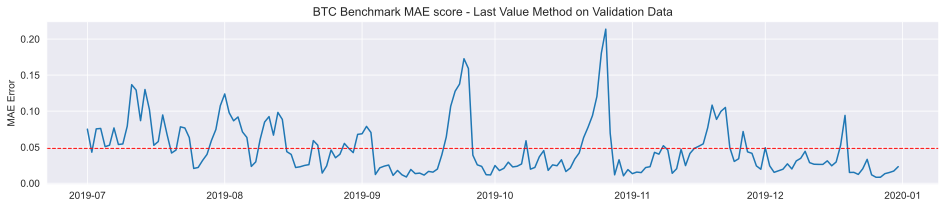

In [196]:
mae_last_value = np.mean(abs(btc_validate.iloc[:,1:].sub(btc_validate.iloc[:,0], axis = 0)).mean(axis = 1))
print('Benchmark MAE score Last Value on Validation Data :', mae_last_value)

plt.figure(figsize=(16,3))
plt.title('BTC Benchmark MAE score - Last Value Method on Validation Data')
plt.ylabel('MAE Error', fontsize = 10)
plt.plot(abs(btc_validate.iloc[:,1:].sub(btc_validate.iloc[:,0], axis = 0)).mean(axis = 1))
_ = plt.axhline(y = mae_last_value, color='r', linestyle='--', linewidth = 1)

In [197]:
MAE_Benchmark_1 = 0.05897302093708246
RMSE_Benchmark_1 = rmse_last_value ** 0.5

Benchmark MAE score Last Value on Test Data : 0.05897302093708246


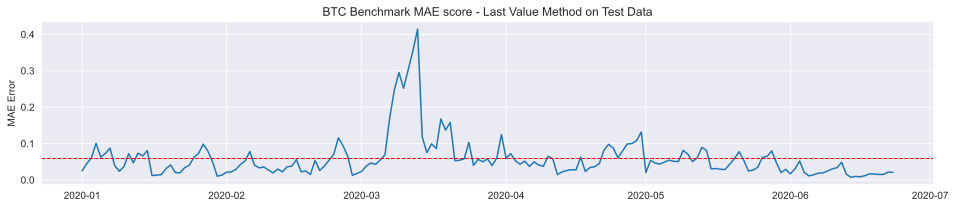

In [198]:
mae_last_value = np.mean(abs(btc_test.iloc[:,1:].sub(btc_test.iloc[:,0], axis = 0)).mean(axis = 1))
print('Benchmark MAE score Last Value on Test Data :', mae_last_value)

plt.figure(figsize=(16,3))
plt.title('BTC Benchmark MAE score - Last Value Method on Test Data')
plt.ylabel('MAE Error', fontsize = 10)
plt.plot(abs(btc_test.iloc[:,1:].sub(btc_test.iloc[:,0], axis = 0)).mean(axis = 1))
_ = plt.axhline(y = mae_last_value, color='r', linestyle='--', linewidth = 1)

In [199]:
mse_last_value = np.mean(np.square(btc_test.iloc[:,1:].sub(btc_test.iloc[:,0], axis = 0)).mean(axis = 1))

In [200]:
MAE_Benchmark_1 = 0.05897302093708246
RMSE_Benchmark_1 = mse_last_value ** 0.5

#####  B. Using an average (e.g. your prediction for each target period is an average of the BTC prices in the lookback period)

In [201]:
btc_df_ben_1 = full_df_merged['BTCPrice']
btc_df_ben_1 = pd.DataFrame(btc_df_ben_1)
#btc_df_ben_1

In [202]:
btc_df_ben_1 = full_df_merged['BTCPrice']
btc_df_ben_1 = pd.DataFrame(btc_df_ben_1)

for i in range(1,8):    
    btc_df_ben_1 = pd.concat([btc_df_ben_1, btc_df_ben_1.iloc[:,0].rolling(window=28).mean()], axis = 1)

btc_df_ben_1 = btc_df_ben_1.dropna()
btc_df_ben_1.columns = ['D'+str(i) for i in range(8)]
#btc_df_ben_1
btc_benchmark_1_df = abs(btc_df_ben_1-btc_df).dropna()
#display(btc_benchmark_1_df)

Benchmark MAE score using Avg Value for Validation data - 0.07248550422750392


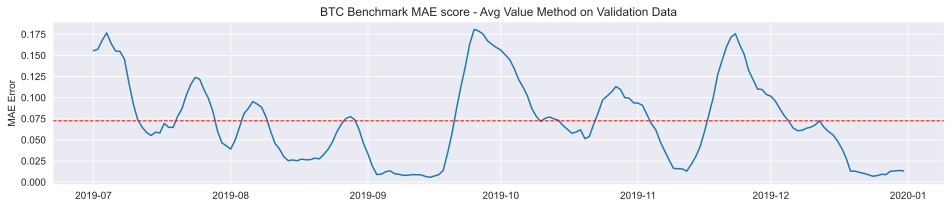

In [203]:
btc_benchmark_1_df_validate = btc_benchmark_1_df.loc[(btc_benchmark_1_df.index >= '2019-07-01') & (btc_benchmark_1_df.index <= '2019-12-31')]
mae_last_value = np.mean(np.mean(btc_benchmark_1_df_validate, axis = 1), axis = 0)
print('Benchmark MAE score using Avg Value for Validation data -', mae_last_value)

plt.figure(figsize=(16,3))
plt.title('BTC Benchmark MAE score - Avg Value Method on Validation Data')
plt.ylabel('MAE Error', fontsize = 10)
plt.plot(np.mean(btc_benchmark_1_df_validate, axis = 1))
_ = plt.axhline(y = mae_last_value, color='r', linestyle='--', linewidth = 1)


Benchmark MAE score using Avg Value for Test data - 0.10289891103194174


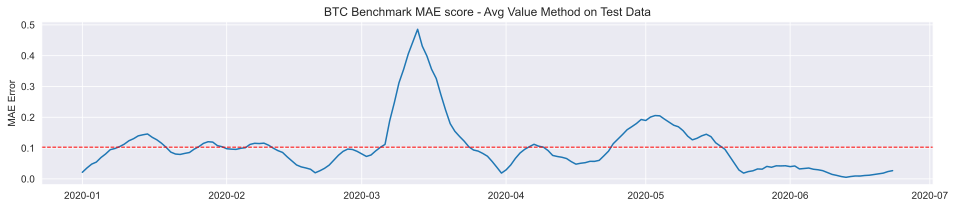

In [204]:
btc_benchmark_1_df_test = btc_benchmark_1_df.loc[(btc_benchmark_1_df.index >= '2020-01-01') & (btc_benchmark_1_df.index <= '2020-06-30')]

mae_last_value = np.mean(np.mean(btc_benchmark_1_df_test, axis = 1), axis = 0)
print('Benchmark MAE score using Avg Value for Test data -', mae_last_value)

plt.figure(figsize=(16,3))
plt.title('BTC Benchmark MAE score - Avg Value Method on Test Data')
plt.ylabel('MAE Error', fontsize = 10)
plt.plot(np.mean(btc_benchmark_1_df_test, axis = 1))
_ = plt.axhline(y = mae_last_value, color='r', linestyle='--', linewidth = 1)

In [209]:
mse_last_value = np.mean(np.square(btc_benchmark_1_df_test))

In [212]:

RMSE_Benchmark_2 = np.mean(mse_last_value)

In [177]:
MAE_Benchmark_2 = 0.10289891103194174

### 2. Build and train a simple neural network by flattening the data, and using 2 (dense)layers and calculate the train and validation loss for each epoch

In [52]:
selected_columns

['BTCPrice',
 'Volume BTC',
 'GBP Curncy',
 'CAD Curncy',
 'SPX Index',
 'TPX Index',
 'BCOM Index',
 'GC1 Comdty',
 'GB3 Govt',
 'GT30 Govt',
 'dayOfWeek']

In [61]:
X_, y_, dates_ = create_data(full_df_merged.loc[:,selected_columns], 
                             is_rnn = False, target_variable = 'BTCPrice',prediction_period = 7)
X_train_, y_train_, X_valid_, y_valid_, X_test_, y_test_, X_, y_ = split_train_valid_test(X_, y_, dates_)

In [67]:
def build_mod_2_f(hp):
    model = keras.models.Sequential()
    model.add(keras.layers.Flatten(input_shape = list(X_train_[0].shape)))
    model.add(keras.layers.Dense(hp.Int("dense_layer_1" , min_value = 32, max_value = 256, step = 32)))
    model.add(keras.layers.ELU(alpha = hp.Float("ELU_layer", min_value = 0.1, max_value = 0.8, step = 0.1)))
    model.add(keras.layers.Dense(7))
    
    model.compile(loss = 'mean_absolute_error', optimizer = hp.Choice('optimizer', ['RMSProp', 'Adadelta', 'Adagrad']))
    return model

In [68]:
mod_2_f_tuner = BayesianOptimization(
    build_mod_2_f,
    objective = 'val_loss',
    max_trials = 4,
    executions_per_trial = 1,
    directory=os.path.normpath('C:/new_dir/2'),
    seed = 42
)

INFO:tensorflow:Reloading Oracle from existing project C:\new_dir\2\untitled_project\oracle.json


In [70]:
mod_2_f_tuner.search(x = X_train_,
                     y = y_train_,
                     epochs = 50,
                     batch_size = 1,
                     validation_data = (X_valid_, y_valid_),
                     verbose = 0)

INFO:tensorflow:Oracle triggered exit


In [108]:
mod_2_f_tuner.get_best_hyperparameters()[0].values

{'dense_layer_1': 237,
 'ELU_layer': 0.30000000000000004,
 'optimizer': 'RMSProp'}

In [124]:
mod_2_f = keras.models.Sequential([
    keras.layers.Flatten(input_shape=list(X_train_[0].shape)),
    keras.layers.Dense(237),
    keras.layers.ELU(alpha = 0.3),
    keras.layers.Dense(7)
])

In [125]:
mod_2_f.compile(loss = 'mean_absolute_error', optimizer = 'RMSProp')

In [126]:
his_2_f = mod_2_f.fit(X_train_, y_train_, epochs=60,
                    validation_data=(X_valid_, y_valid_),
                     verbose = 0)

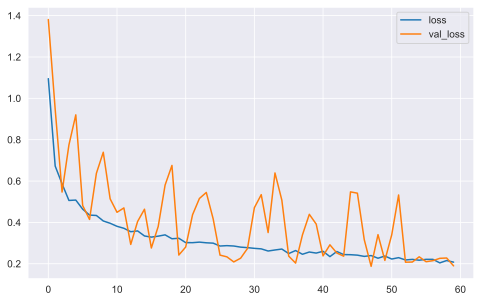

In [127]:
pd.DataFrame(his_2_f.history).plot(figsize=(8, 5))
plt.grid(True)
#plt.gca().set_ylim(0.0, 0.3) # set the vertical range to [0-1]
plt.show()

In [170]:
MAE_SIMPLE_NN = mean_absolute_error(np.squeeze(y_test_), mod_2_f.predict(X_test_))
RMSE_SIMPLE_NN = mean_squared_error(np.squeeze(y_test_), mod_2_f.predict(X_test_)) ** 0.5

### 3. Build and train an RNN model with an LSTM layer and print the train and validation loss

In [84]:
X, y, dates = create_data(full_df_merged.loc[:,selected_columns], 
                          is_rnn = True, target_variable = 'BTCPrice',prediction_period = 7)
X_train, y_train, X_valid, y_valid, X_test, y_test, X, y = split_train_valid_test(X, y, dates)

In [85]:
def build_mod_3_f(hp):
    
    model = keras.models.Sequential([
        keras.layers.LSTM(hp.Int('ltsm1', min_value = 20, max_value = 100, step = 5), return_sequences=True, input_shape=[None, X_train.shape[2]]),
        keras.layers.TimeDistributed(keras.layers.Dense(7))
    ])
    
   # model = keras.models.Sequential()
   # model.add(keras.layers.LSTM(hp.Int('ltsm1', min_value = 20, max_value = 100, step = 5), return_sequences = True, input_shape=[None, X_train.shape[2]]))
   # model.add(keras.layers.TimeDistributed(keras.layers.Dense(7)))
    
    model.compile(loss = 'mean_absolute_error', optimizer = hp.Choice('optimizer', ['RMSProp', 'Adadelta', 'Adagrad']))
    
    return model

In [87]:
mod_3_f_tuner = BayesianOptimization(
    build_mod_3_f,
    objective = 'val_loss',
    max_trials = 4,
    executions_per_trial = 1,
    directory=os.path.normpath('C:/new_dir/7'),
    seed = 42
)

In [92]:
mod_3_f_tuner.search(x = X_train,
                     y = y_train,
                     epochs = 50,
                     batch_size = 1,
                     validation_data = (X_valid, y_valid),
                     verbose = 0)

INFO:tensorflow:Oracle triggered exit


In [129]:
mod_3_f_tuner.get_best_hyperparameters()[0].values

{'ltsm1': 70, 'optimizer': 'RMSProp'}

In [133]:
mod_3_f = keras.models.Sequential([
    keras.layers.LSTM(70, return_sequences=True, input_shape=[None, X_train.shape[2]]),
    keras.layers.TimeDistributed(keras.layers.Dense(7))
])

In [134]:
mod_3_f.compile(loss = 'mean_absolute_error', optimizer='RMSProp')

In [135]:
his_3_f = mod_3_f.fit(X_train, y_train, epochs=60,
                     validation_data=(X_test, y_test),
                      verbose = 0)

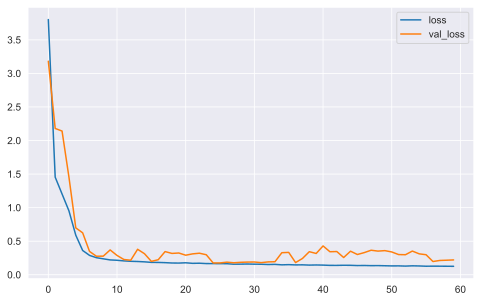

In [136]:
pd.DataFrame(his_3_f.history).plot(figsize=(8, 5))
plt.grid(True)
#plt.gca().set_ylim(0.0, 0.3) # set the vertical range to [0-1]
plt.show()

In [173]:
MAE_LSTM = mean_absolute_error(mod_3_f.predict(X_test_)[:,-1], np.squeeze(y_test_))
RMSE_LSTM = mean_squared_error(mod_3_f.predict(X_test_)[:,-1], np.squeeze(y_test_)) ** 0.5

### 4. Build and train an RNN model with a GRU layer and print the train and validation loss

In [99]:
def build_mod_4_f(hp):
    model = keras.models.Sequential([
        keras.layers.GRU(hp.Int('gru1', min_value = 20, max_value = 100, step = 5), return_sequences=True, input_shape=[None, X_train.shape[2]]),
        keras.layers.TimeDistributed(keras.layers.Dense(7))
    ]) 
    
    model.compile(loss = 'mean_absolute_error', optimizer = hp.Choice('optimizer', ['RMSProp', 'Adadelta', 'Adagrad']))
    
    return model

In [100]:
mod_4_f_tuner = BayesianOptimization(
    build_mod_4_f,
    objective = 'val_loss',
    max_trials = 3,
    executions_per_trial = 1,
    directory=os.path.normpath('C:/new_dir/8'),
    seed = 42
)

In [101]:
mod_4_f_tuner.search(x = X_train,
                     y = y_train,
                     epochs = 50,
                     batch_size = 1,
                     validation_data = (X_valid, y_valid),
                     verbose = 0)

INFO:tensorflow:Oracle triggered exit


In [139]:
mod_4_f_tuner.get_best_hyperparameters()[0].values

{'gru1': 70, 'optimizer': 'RMSProp'}

In [145]:
mod_4_f = keras.models.Sequential([
    keras.layers.GRU(70, return_sequences=True, input_shape=[None, X_test.shape[2]]),
    keras.layers.TimeDistributed(keras.layers.Dense(7))
])

In [146]:
mod_4_f.compile(loss = 'mean_absolute_error', optimizer='RMSProp')

In [147]:
his_4_f = mod_4_f.fit(X_train, y_train, epochs=50,
                     validation_data=(X_test, y_test),
                      verbose = 0)

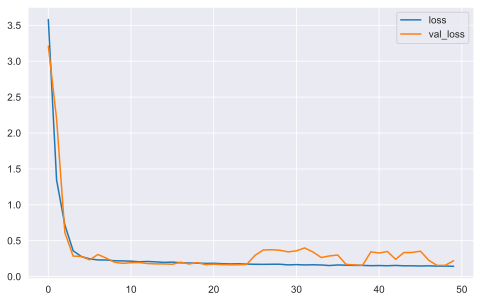

In [148]:
pd.DataFrame(his_4_f.history).plot(figsize=(8, 5))
plt.grid(True)
#plt.gca().set_ylim(0.0, 0.3) # set the vertical range to [0-1]
plt.show()

In [172]:
MAE_RNN_GRU = mean_absolute_error(mod_4_f.predict(X_test_)[:,-1], np.squeeze(y_test_))
RMSE_RNN_GRU = mean_squared_error(mod_4_f.predict(X_test_)[:,-1], np.squeeze(y_test_)) ** 0.5

### 5. Build and train an RNN model with a GRU layer and recurrent dropout and print the train and validation loss for each epoch

In [104]:
## Bayesian optimization code for GRU Layer with recurrnet dropout
'''
def build_mod_5_f(hp):
    model = keras.models.Sequential([
        keras.layers.GRU(hp.Int('grurec1', min_value = 20, max_value = 100, step = 5), 
                         recurrent_dropout = hp.Float("rec_drop", min_value = 0.1, max_value = 0.8, step = 0.1), 
                         return_sequences=True, input_shape=[None, X_test.shape[2]]),
        keras.layers.TimeDistributed(keras.layers.Dense(7))
    ])
    
    model.compile(loss = 'mean_absolute_error', optimizer = hp.Choice('optimizer', ['RMSProp', 'Adadelta','Adagrad']))
    
    return model

mod_5_f_tuner = BayesianOptimization(
    build_mod_5_f,
    objective = 'val_loss',
    max_trials = 4,
    executions_per_trial = 1,
    directory=os.path.normpath('C:/new_dir/9'),
    seed = 42
)

mod_5_f_tuner.search(x = X_train,
                     y = y_train,
                     epochs = 30,
                     batch_size = 1,
                     validation_data = (X_valid, y_valid),
                     verbose = 0)

mod_5_f = mod_5_f_tuner.get_best_models()[0]
'''

In [161]:
mod_5_f = keras.models.Sequential([
    keras.layers.GRU(70, recurrent_dropout = 0.1, return_sequences=True, input_shape=[None, X_train.shape[2]]),
    keras.layers.TimeDistributed(keras.layers.Dense(7))
])

In [162]:
mod_5_f.compile(loss = 'mean_absolute_error', optimizer='RMSProp')

In [163]:
his_5_f = mod_5_f.fit(X_train, y_train, epochs=30,
                    validation_data=(X_test, y_test))

Epoch 1/30
44/44 [==============================] - ETA: 0s - loss: 7.468 - ETA: 2s - loss: 7.060 - ETA: 2s - loss: 6.726 - ETA: 2s - loss: 6.627 - ETA: 3s - loss: 6.502 - ETA: 3s - loss: 6.351 - ETA: 3s - loss: 6.227 - ETA: 3s - loss: 6.163 - ETA: 3s - loss: 6.013 - ETA: 3s - loss: 5.948 - ETA: 3s - loss: 5.836 - ETA: 3s - loss: 5.719 - ETA: 3s - loss: 5.624 - ETA: 2s - loss: 5.536 - ETA: 2s - loss: 5.417 - ETA: 2s - loss: 5.308 - ETA: 2s - loss: 5.184 - ETA: 2s - loss: 5.060 - ETA: 2s - loss: 4.946 - ETA: 2s - loss: 4.835 - ETA: 2s - loss: 4.749 - ETA: 2s - loss: 4.647 - ETA: 2s - loss: 4.557 - ETA: 2s - loss: 4.463 - ETA: 1s - loss: 4.387 - ETA: 1s - loss: 4.303 - ETA: 1s - loss: 4.230 - ETA: 1s - loss: 4.149 - ETA: 1s - loss: 4.088 - ETA: 1s - loss: 4.026 - ETA: 1s - loss: 3.954 - ETA: 1s - loss: 3.895 - ETA: 1s - loss: 3.830 - ETA: 1s - loss: 3.773 - ETA: 0s - loss: 3.714 - ETA: 0s - loss: 3.666 - ETA: 0s - loss: 3.617 - ETA: 0s - loss: 3.551 - ETA: 0s - loss: 3.502 - ETA: 0s - lo

44/44 [==============================] - ETA: 0s - loss: 0.245 - ETA: 1s - loss: 0.228 - ETA: 2s - loss: 0.209 - ETA: 2s - loss: 0.198 - ETA: 2s - loss: 0.186 - ETA: 2s - loss: 0.183 - ETA: 2s - loss: 0.179 - ETA: 2s - loss: 0.179 - ETA: 2s - loss: 0.187 - ETA: 2s - loss: 0.194 - ETA: 2s - loss: 0.200 - ETA: 2s - loss: 0.199 - ETA: 2s - loss: 0.197 - ETA: 2s - loss: 0.195 - ETA: 2s - loss: 0.197 - ETA: 2s - loss: 0.200 - ETA: 2s - loss: 0.203 - ETA: 2s - loss: 0.203 - ETA: 2s - loss: 0.204 - ETA: 2s - loss: 0.203 - ETA: 2s - loss: 0.202 - ETA: 2s - loss: 0.202 - ETA: 1s - loss: 0.202 - ETA: 1s - loss: 0.204 - ETA: 1s - loss: 0.204 - ETA: 1s - loss: 0.202 - ETA: 1s - loss: 0.202 - ETA: 1s - loss: 0.201 - ETA: 1s - loss: 0.201 - ETA: 1s - loss: 0.199 - ETA: 1s - loss: 0.199 - ETA: 1s - loss: 0.199 - ETA: 1s - loss: 0.197 - ETA: 0s - loss: 0.197 - ETA: 0s - loss: 0.196 - ETA: 0s - loss: 0.196 - ETA: 0s - loss: 0.197 - ETA: 0s - loss: 0.198 - ETA: 0s - loss: 0.198 - ETA: 0s - loss: 0.197 -

44/44 [==============================] - ETA: 0s - loss: 0.202 - ETA: 2s - loss: 0.193 - ETA: 2s - loss: 0.189 - ETA: 3s - loss: 0.193 - ETA: 3s - loss: 0.191 - ETA: 3s - loss: 0.189 - ETA: 3s - loss: 0.180 - ETA: 3s - loss: 0.177 - ETA: 3s - loss: 0.175 - ETA: 3s - loss: 0.172 - ETA: 2s - loss: 0.169 - ETA: 2s - loss: 0.172 - ETA: 2s - loss: 0.173 - ETA: 2s - loss: 0.171 - ETA: 2s - loss: 0.169 - ETA: 2s - loss: 0.166 - ETA: 2s - loss: 0.164 - ETA: 2s - loss: 0.164 - ETA: 2s - loss: 0.162 - ETA: 2s - loss: 0.161 - ETA: 2s - loss: 0.159 - ETA: 2s - loss: 0.160 - ETA: 1s - loss: 0.160 - ETA: 1s - loss: 0.163 - ETA: 1s - loss: 0.162 - ETA: 1s - loss: 0.161 - ETA: 1s - loss: 0.161 - ETA: 1s - loss: 0.161 - ETA: 1s - loss: 0.162 - ETA: 1s - loss: 0.161 - ETA: 1s - loss: 0.160 - ETA: 1s - loss: 0.160 - ETA: 1s - loss: 0.159 - ETA: 0s - loss: 0.158 - ETA: 0s - loss: 0.158 - ETA: 0s - loss: 0.158 - ETA: 0s - loss: 0.158 - ETA: 0s - loss: 0.158 - ETA: 0s - loss: 0.158 - ETA: 0s - loss: 0.158 -

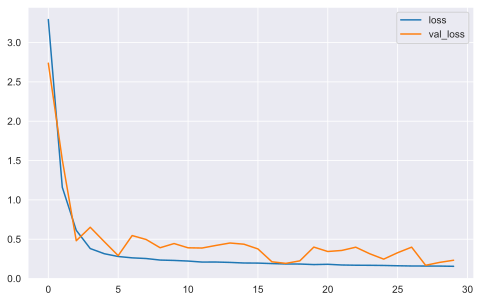

In [164]:
pd.DataFrame(his_5_f.history).plot(figsize=(8, 5))
plt.grid(True)
#plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.show()

In [174]:
MAE_GRU_RECURRENT = mean_absolute_error(mod_5_f.predict(X_test_)[:,-1], np.squeeze(y_test_))
RMSE_GRU_RECURRENT = mean_squared_error(mod_5_f.predict(X_test_)[:,-1], np.squeeze(y_test_)) ** 0.5

### 6. Add an additional GRU layer to (5) above with dropout and recurrent dropout and print the train and validation loss

In [ ]:
## Bayesian optimization code for GRU Layer with recurrnet dropout and dropout layer
'''
def build_mod_6_f(hp)
    mod_6_f = keras.models.Sequential([
        keras.layers.GRU(hp.Int('grurec1', min_value = 20, max_value = 100, step = 5), 
                         recurrent_dropout = 0.1 ,
                         return_sequences=True, input_shape=[None, X_test.shape[2]]),
        keras.layers.GRU(hp.Int('grurec2', min_value = 20, max_value = 100, step = 5), 
                         recurrent_dropout = 0.1, 
                         dropout = 0.1, return_sequences = True),
        keras.layers.TimeDistributed(keras.layers.Dense(7))
    ])
    
    model.compile(loss = 'mean_absolute_error', optimizer = hp.Choice('optimizer', ['RMSProp', 'Adagrad']))

mod_6_f_tuner = BayesianOptimization(
    build_mod_6_f,
    objective = 'val_loss',
    max_trials = 2,
    executions_per_trial = 1,
    directory=os.path.normpath('C:/new_dir/10'),
    seed = 42
)

mod_6_f_tuner.search(x = X_train,
                     y = y_train,
                     epochs = 20,
                     batch_size = 1,
                     validation_data = (X_valid, y_valid),
                     verbose = 0)

mod_6_f = mod_5_f_tuner.get_best_models()[0]
'''

In [166]:
mod_6_f = keras.models.Sequential([
    keras.layers.GRU(70, recurrent_dropout = 0.1 ,return_sequences=True, input_shape=[None, X_test.shape[2]]),
    keras.layers.GRU(40, recurrent_dropout = 0.1, dropout = 0.1, return_sequences = True),
    keras.layers.TimeDistributed(keras.layers.Dense(7))
])

In [167]:
mod_6_f.compile(loss = 'mean_absolute_error', optimizer='RMSprop')

In [168]:
his_6_f = mod_6_f.fit(X_train, y_train, epochs=20,
                    validation_data=(X_test, y_test))

Epoch 1/20
44/44 [==============================] - ETA: 0s - loss: 7.356 - ETA: 4s - loss: 6.939 - ETA: 5s - loss: 6.632 - ETA: 6s - loss: 6.313 - ETA: 6s - loss: 6.091 - ETA: 6s - loss: 5.956 - ETA: 6s - loss: 5.878 - ETA: 6s - loss: 5.759 - ETA: 6s - loss: 5.611 - ETA: 6s - loss: 5.502 - ETA: 6s - loss: 5.389 - ETA: 6s - loss: 5.281 - ETA: 6s - loss: 5.202 - ETA: 6s - loss: 5.109 - ETA: 5s - loss: 5.033 - ETA: 5s - loss: 4.938 - ETA: 5s - loss: 4.868 - ETA: 5s - loss: 4.811 - ETA: 5s - loss: 4.749 - ETA: 4s - loss: 4.681 - ETA: 4s - loss: 4.630 - ETA: 4s - loss: 4.580 - ETA: 4s - loss: 4.530 - ETA: 4s - loss: 4.500 - ETA: 3s - loss: 4.458 - ETA: 3s - loss: 4.413 - ETA: 3s - loss: 4.364 - ETA: 3s - loss: 4.326 - ETA: 3s - loss: 4.281 - ETA: 2s - loss: 4.234 - ETA: 2s - loss: 4.190 - ETA: 2s - loss: 4.155 - ETA: 2s - loss: 4.124 - ETA: 2s - loss: 4.090 - ETA: 1s - loss: 4.052 - ETA: 1s - loss: 4.019 - ETA: 1s - loss: 3.969 - ETA: 1s - loss: 3.932 - ETA: 1s - loss: 3.904 - ETA: 0s - lo

44/44 [==============================] - ETA: 0s - loss: 0.222 - ETA: 4s - loss: 0.253 - ETA: 6s - loss: 0.273 - ETA: 7s - loss: 0.274 - ETA: 7s - loss: 0.268 - ETA: 7s - loss: 0.269 - ETA: 7s - loss: 0.254 - ETA: 7s - loss: 0.244 - ETA: 6s - loss: 0.238 - ETA: 6s - loss: 0.241 - ETA: 6s - loss: 0.237 - ETA: 6s - loss: 0.238 - ETA: 6s - loss: 0.240 - ETA: 6s - loss: 0.237 - ETA: 6s - loss: 0.237 - ETA: 6s - loss: 0.240 - ETA: 5s - loss: 0.239 - ETA: 5s - loss: 0.237 - ETA: 5s - loss: 0.237 - ETA: 5s - loss: 0.234 - ETA: 4s - loss: 0.231 - ETA: 4s - loss: 0.232 - ETA: 4s - loss: 0.234 - ETA: 4s - loss: 0.236 - ETA: 4s - loss: 0.235 - ETA: 3s - loss: 0.236 - ETA: 3s - loss: 0.237 - ETA: 3s - loss: 0.237 - ETA: 3s - loss: 0.237 - ETA: 3s - loss: 0.235 - ETA: 2s - loss: 0.234 - ETA: 2s - loss: 0.233 - ETA: 2s - loss: 0.233 - ETA: 2s - loss: 0.233 - ETA: 1s - loss: 0.233 - ETA: 1s - loss: 0.232 - ETA: 1s - loss: 0.232 - ETA: 1s - loss: 0.235 - ETA: 1s - loss: 0.236 - ETA: 0s - loss: 0.236 -

In [175]:
MAE_GRU_2 = mean_absolute_error(mod_6_f.predict(X_test_)[:,-1], np.squeeze(y_test_))
RMSE_GRU_2 = mean_squared_error(mod_6_f.predict(X_test_)[:,-1], np.squeeze(y_test_)) ** 0.5

## Part 4: Evaluation

In [213]:
d = {'MAE': [MAE_Benchmark_1,MAE_Benchmark_1, MAE_SIMPLE_NN, MAE_LSTM, MAE_RNN_GRU, MAE_GRU_RECURRENT,MAE_GRU_2 ], 'RMSE': [RMSE_Benchmark_1,RMSE_Benchmark_2 ,RMSE_SIMPLE_NN, RMSE_LSTM, RMSE_RNN_GRU, RMSE_GRU_RECURRENT,RMSE_GRU_2]}
df = pd.DataFrame(d)
results = df.rename(index={0: 'Benchmark_1(Last)',1: 'Benchmark_2(Average)', 2: 'SIMPLE_NN', 3: 'LSTM', 4: 'RNN_GRU', 5: 'GRU_RECURRENT', 6: 'GRU_2'})
results

MAE      RMSE
Benchmark_1(Last)     0.058973  0.094930
Benchmark_2(Average)  0.058973  0.022723
SIMPLE_NN             0.215410  0.315966
LSTM                  0.162014  0.205043
RNN_GRU               0.140594  0.169496
GRU_RECURRENT         0.152134  0.183625
GRU_2                 0.091895  0.015937

##### Although we have tried a lot of deep learning models we weren't able to beat the benchmark models. LSTM and Simple Neural Networks gave good results followed by GRU based models. 
##### GRU model with recurrent dropout and dropout layer performed the best. Our intuition is it allowed paramters to identify patterns in the time series
##### LSTM performs brilliantly with time series data as it works very well with multivariate data and is adept at handling multiple features at a time
##### The advantage of an LSTM cell compared to a common recurrent unit is its cell memory unit. The cell vector has the ability to encapsulate the notion of forgetting part of its previously stored memory, as well as to add part of the new information, This might be the reason why the LSTM models are performing better than GRU models
##### Although GRU based models over here are faster and consume less memory, LSTM models are more accurate when considering a larger sequence
##### The Benchmark models gave better results when the lookback period was 7 days instead of the 28 days used earlier
##### Results predicted using the feed forward neural network are quite volatile as compared to the other models
